In [95]:
#     solarWindPlots.ipynb
#
#     Standard Python Dependencies: numpy, astropy, matplotlib
#     Custom Dependencies: solarWindTools.py
#     parReader.py
#     
#     This notebook is used to test the functionality of solarWindPlots.py
#
#     Written by Noelle Feist
#     2022 Cornell Astrophysics REU
#     Funded by NSF award NST/AST-1950324
#
#     Thanks to Shami Chatterjee, Thankful Cromartie, and Jim Cordes for guiding me through the analyses conducted.

In [96]:
#import statements from standard packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.time import Time
from astropy.timeseries import LombScargle
from astropy.coordinates import get_sun
import math
import matplotlib.gridspec as gridspec
import os
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (10, 5)

#import from custom files (parReader.py and solarWindTools.py)
from parReader import Pulsar
from solarWindTools import Z0
from solarWindTools import sinfit
from solarWindTools import expfit
from solarWindTools import expfit2

In [97]:
#setup
folder = "/Users/noellefeist/Desktop/Stuff/Research/SOLAR_WIND_SUBTRACTION/15yr_all"
filename = "J0030+0451_PINT_20210928.wb.par"

pulsarname = filename[:-4] #store the name of the pulsar
narrowband = True #check to see if this is narrowband or wideband
try:
    filename[:-4].index("wb") #if wideband, set narrowband to false (assuming that the file is wideband iff the filename containts 'wb')
    narrowband = False
except:
    pass
p1 = Pulsar(folder + "/" + filename) #read Pulsar data from .par file, put into Pulsar object

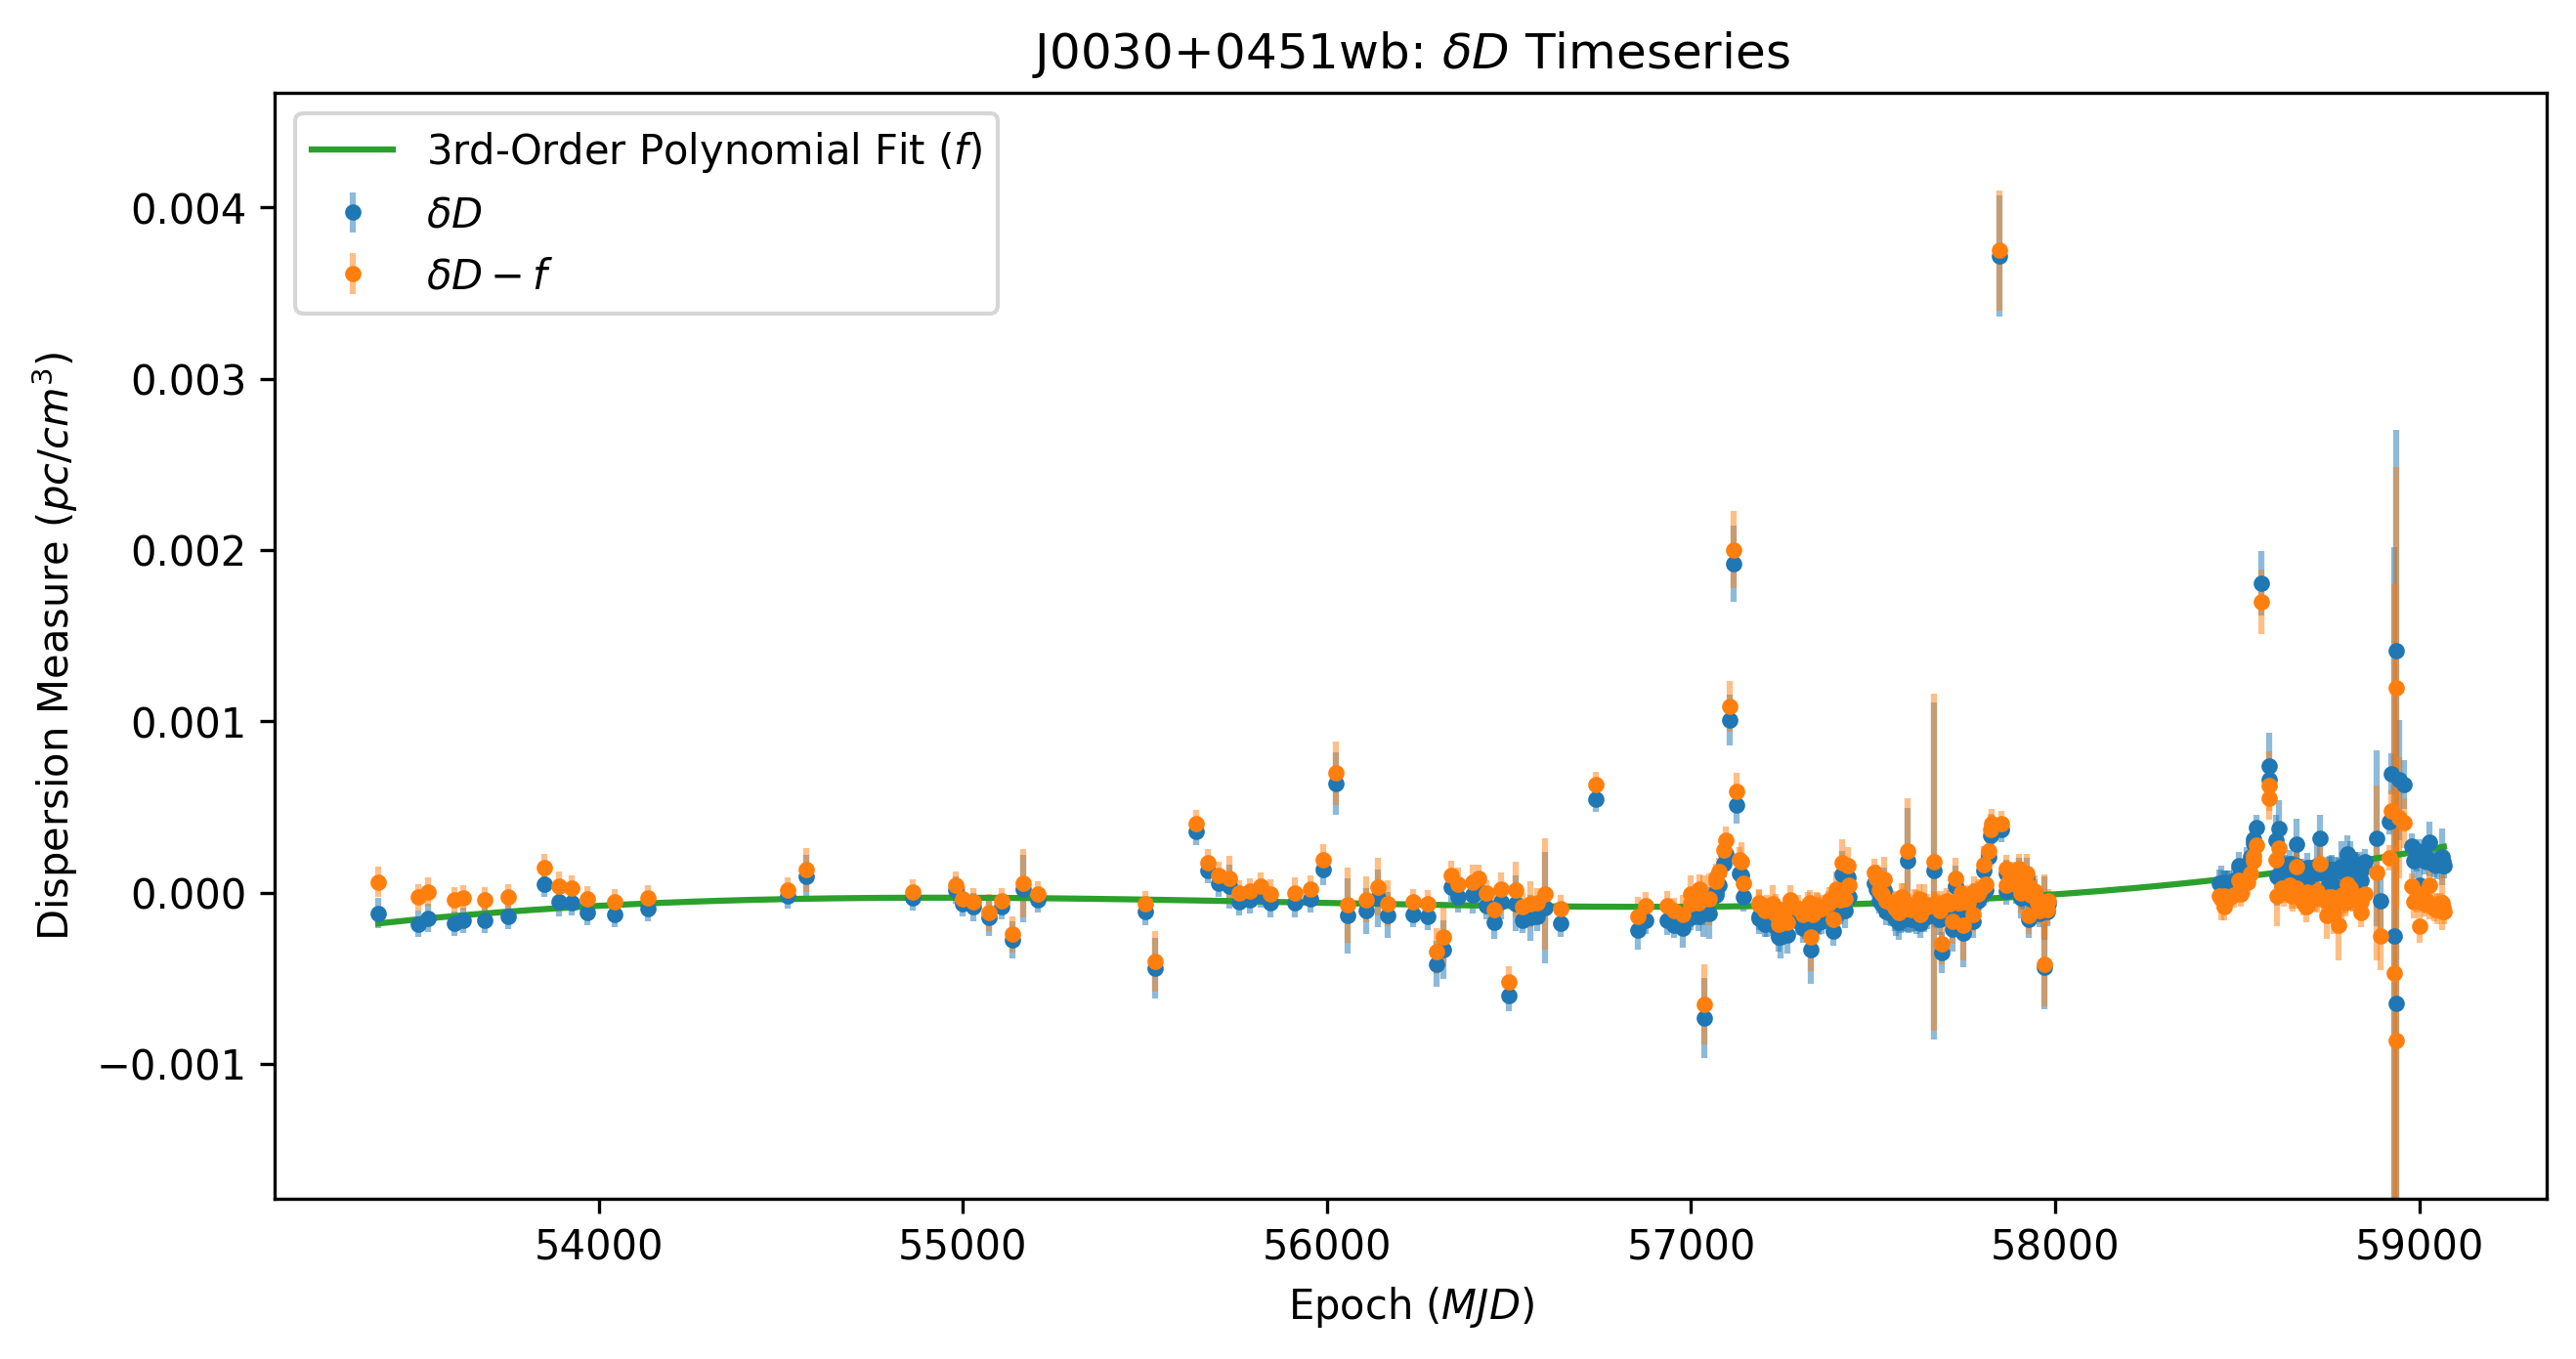

In [98]:
#fit a 3rd-Order Polynomial to dD to (approx.) remove all non-periodic components
popt, pcov = np.polyfit(p1.DMXEP_ARR, p1.DMX_ARR, 3, w=1/p1.DMX_ERROR_ARR, full=False, cov=True)
polyfit = np.polyval([*popt], p1.DMXEP_ARR)
xaxis = np.linspace(p1.DMXEP_ARR.min(), p1.DMXEP_ARR.max(), 200) #the xaxis used for the plot of the poly3, higher res

#remove the fitted 3rd-Order Polynomial from dD
periodicDMX = p1.DMX_ARR - polyfit

#plot the fitted 3rd-Order Polynomial and the original data
markers, caps, bars = plt.errorbar(p1.DMXEP_ARR, p1.DMX_ARR, p1.DMX_ERROR_ARR, fmt=".") #plot the original dmx
[bar.set_alpha(0.5) for bar in bars] #make the bars semi-transparent
markers, caps, bars = plt.errorbar(p1.DMXEP_ARR, periodicDMX, p1.DMX_ERROR_ARR, fmt=".") #plot the dD - poly3 fit
[bar.set_alpha(0.5) for bar in bars]
plt.plot(xaxis, np.polyval([*popt], xaxis)) #show what the fit looks like
plt.ylabel(r"Dispersion Measure $(pc/cm^3)$")
max = np.max(np.array([periodicDMX.max(), p1.DMX_ARR.max()])) #used to set the boundaries of the plot manually, enables the plot to actually be read
min = np.min(np.array([periodicDMX.min(), p1.DMX_ARR.min()])) #even if the error bars are stupidly big
diff = max-min
plt.ylim([min - 0.2*diff, max + 0.2*diff]) #apply the bounds
plt.xlabel(r"Epoch $(MJD)$")
plt.legend([r"3rd-Order Polynomial Fit $(f)$",r"$\delta D$", r"$\delta D-f$"])
plt.title(p1.PSR + ("nb" if narrowband else "wb") +r": $\delta D$ Timeseries")
plt.show()

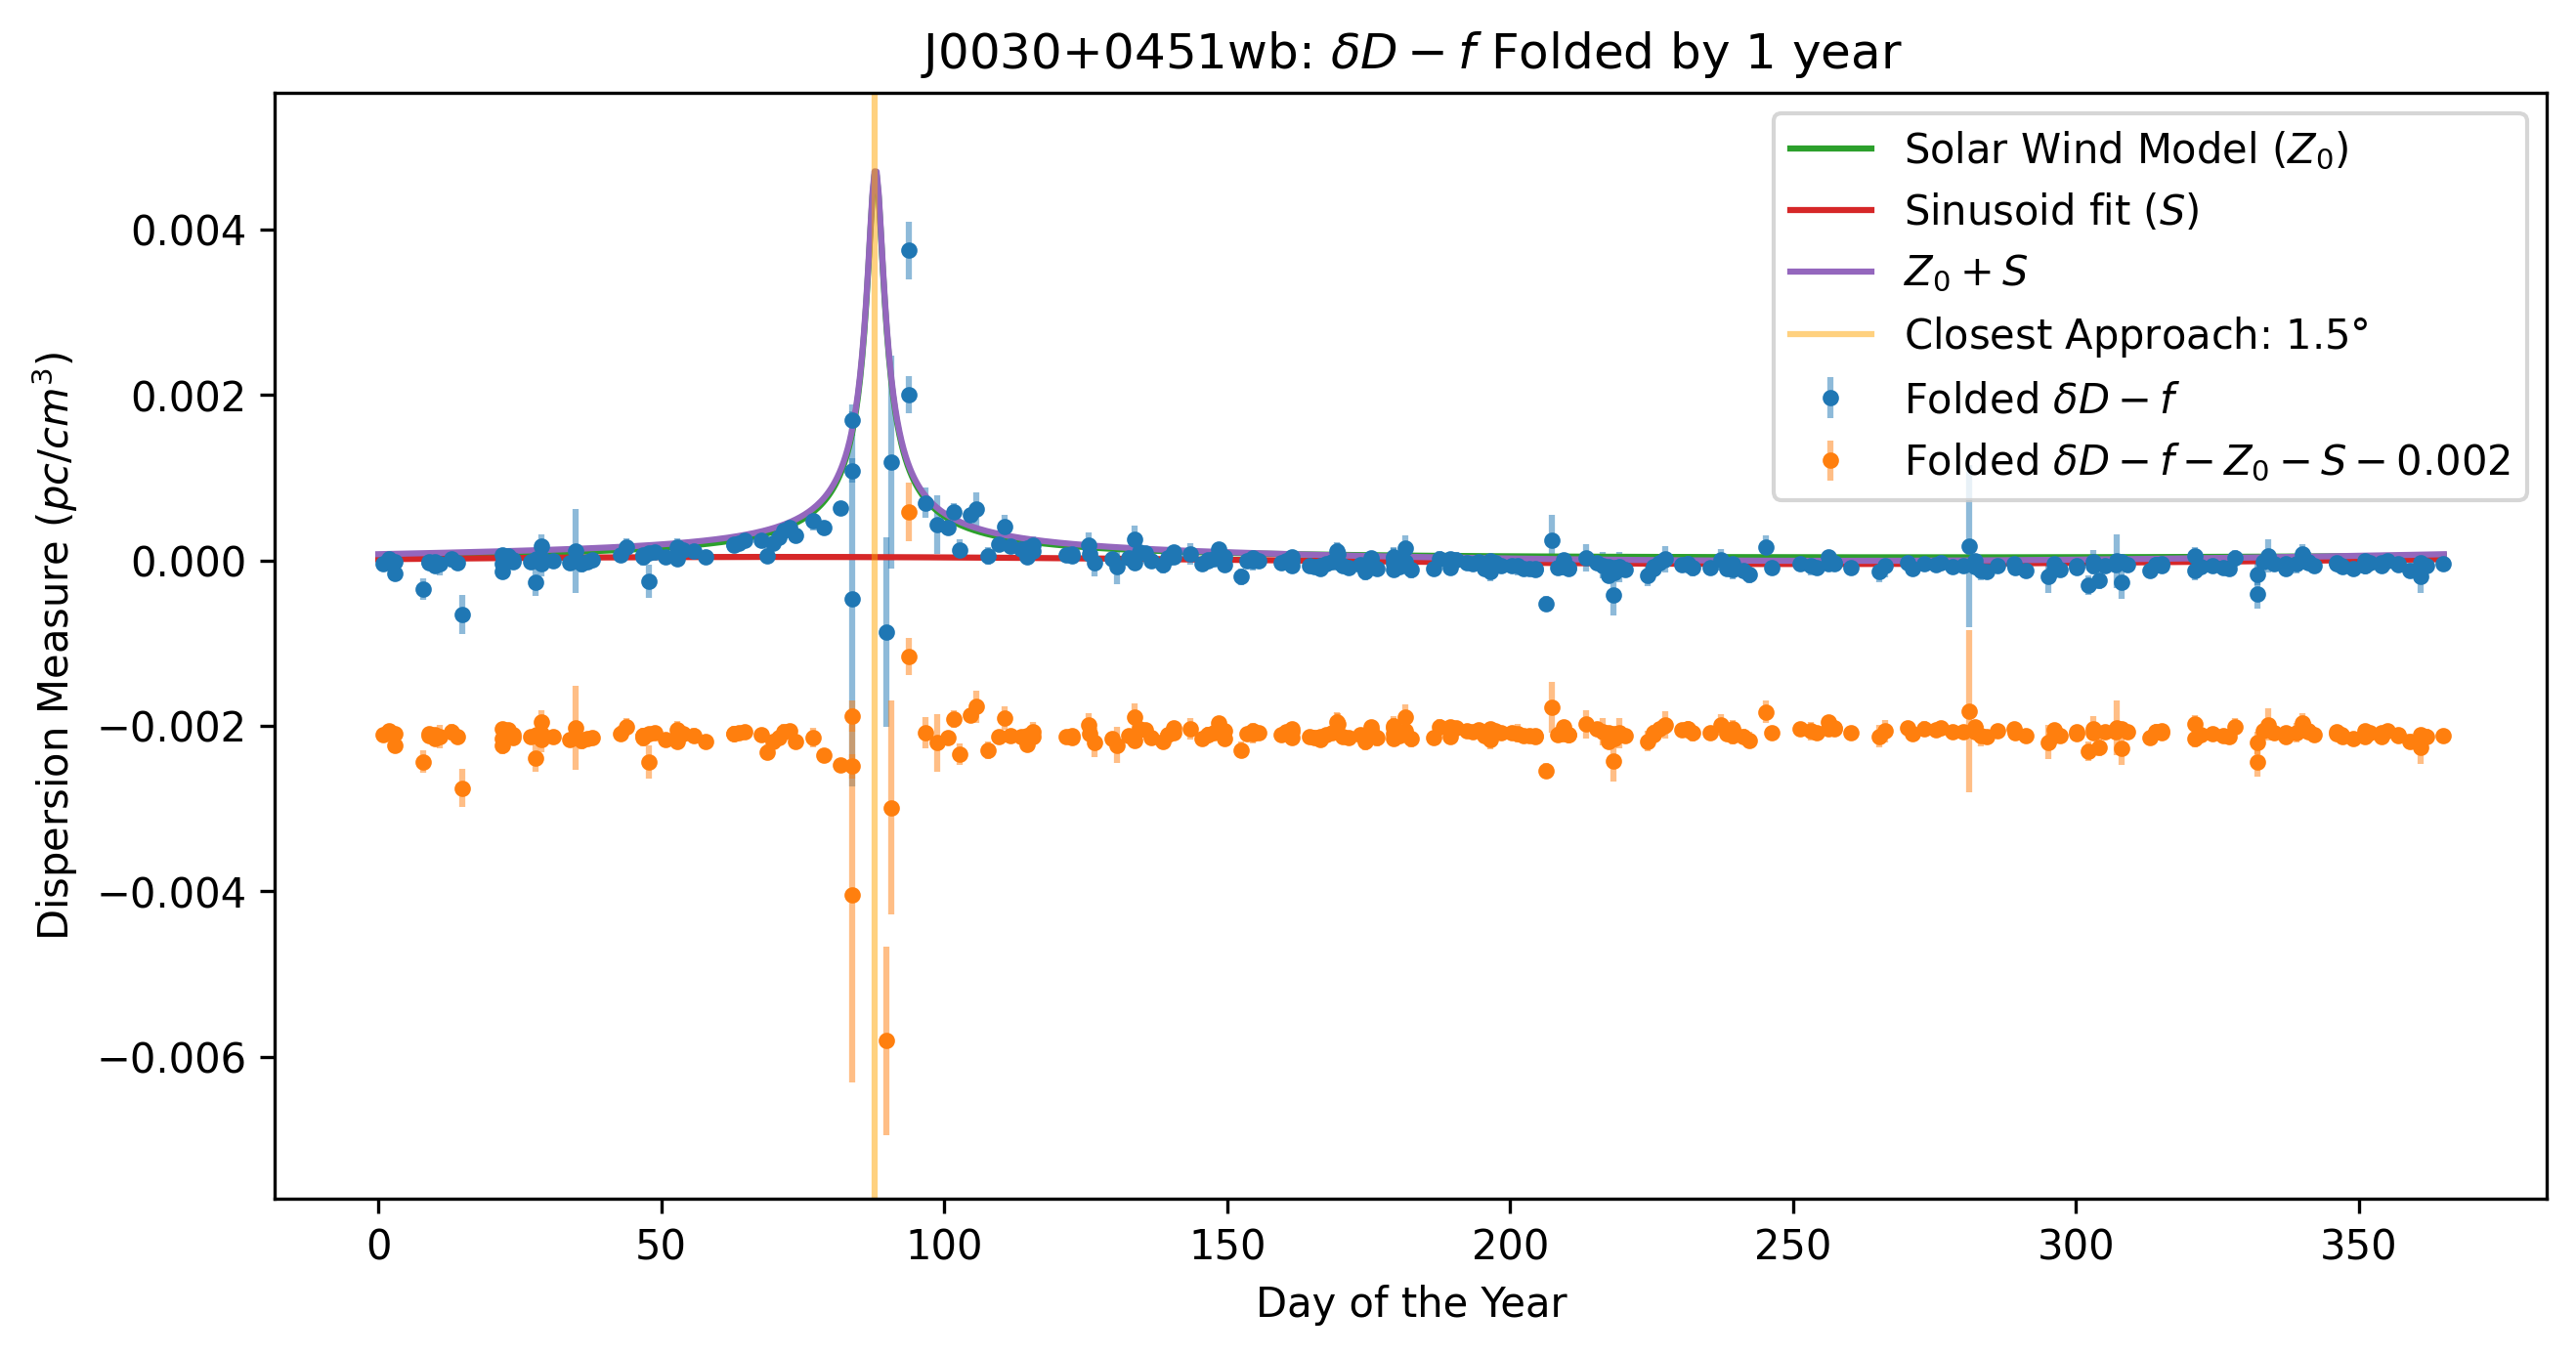

In [99]:
#set up plot for folded
daysSince1Jan2010 = p1.DMXEP_ARR - 55197 #55197 is Jan 1 2010 in MJD, this is an arbitrary day
daysSince1Jan = np.mod(daysSince1Jan2010, 365) #days since Jan 1 between 0 and 365 (phase)

#sorts the various array by phase (from Jan to Dec)
orderedIndices = np.argsort(daysSince1Jan) #provides indices that would sort the days in order, and use that to sort the other arrays
sortedDaysSince1Jan = daysSince1Jan[orderedIndices]
sortedPeriodicDMX = periodicDMX[orderedIndices]
sortedDMXEP = p1.DMXEP_ARR[orderedIndices]
sortedDMX_ERROR = p1.DMX_ERROR_ARR[orderedIndices]

pulsarSkyCoord = p1.SkyCoord() #create a astropy SkyCoord object for the pulsar

xaxis = np.linspace(0, 365, 1000) #used for plotting Z_0 and S for a higher-resolution plot
t = Time(xaxis + 55197, format="mjd")
t1 = Time(sortedDaysSince1Jan + 55197, format='mjd') #used to adjust the values of the data (same number of points as data points)
Z0_plot, theta = Z0(t, p1, returnAngle=True) #angle is kept to find the closest approach and what that is, these points are used for the plot
Z0_plot *= 7.9 #amplitude from Madison, D et al 2018
Z0_each_point, theta1, pulsar_ras, pulsar_decs = Z0(t1, p1, returnAngle=True, returnCoords=True) #these points are used to adjust the data
Z0_each_point *= 7.9

#fit a Sinusoid to dD-Z_0
popt, pcov = curve_fit(sinfit, sortedDaysSince1Jan[theta1 > np.pi/9] + 55197, sortedPeriodicDMX[theta1 > np.pi/9]  - Z0_each_point[theta1 > np.pi/9]  , sigma=sortedDMX_ERROR[theta1 > np.pi/9] ) #apply the fit of the sinusoid

sinusoid_plot = popt[0]*np.sin(2*np.pi * (t.mjd - popt[1])/365) #sinusoid fit that is plotted
sinusoid_each_point = popt[0]*np.sin(2*np.pi * (t1.mjd - popt[1])/365) #sinusoid fit that is used to adjust the data
combined_plot = Z0_plot + sinusoid_plot

#plot folded data and fits
markers, caps, bars = plt.errorbar(sortedDaysSince1Jan, sortedPeriodicDMX, sortedDMX_ERROR, fmt='.', label=r"Folded $\delta D-f$") #plot folded periodic component of dD (dD-f)
[bar.set_alpha(0.5) for bar in bars]
adjSortedPeriodicDMX = sortedPeriodicDMX - Z0_each_point - sinusoid_each_point - 0.002
markers, caps, bars = plt.errorbar(sortedDaysSince1Jan, adjSortedPeriodicDMX, sortedDMX_ERROR, fmt='.', label=r"Folded $\delta D-f-Z_0-S-0.002$") #plot the adjusted folded periodic component of dD (dD-f-S-Z_0)
[bar.set_alpha(0.5) for bar in bars]
plt.ylabel(r"Dispersion Measure $(pc/cm^3)$")
plt.xlabel("Day of the Year")
plt.plot(xaxis, Z0_plot, label=r"Solar Wind Model $(Z_0)$", color="tab:green") #plot Z_0
plt.plot(xaxis, sinusoid_plot, label=r"Sinusoid fit $(S)$", color="tab:red") #plot S
plt.plot(xaxis, combined_plot, label=r"$Z_0+S$", color="tab:purple") #plot Z_0+S
closestapproach = theta.min()*180/np.pi
plt.axvline(xaxis[theta.argmin()], color="orange", alpha=0.5, label="Closest Approach: " + "{:.1f}".format(closestapproach) + r"$\degree$") #create the vertical line for the closest approach
plt.legend()
plt.title(p1.PSR + ("nb" if narrowband else "wb") +r": $\delta D-f$ Folded by 1 year")
max = np.max(np.array([periodicDMX.max(), adjSortedPeriodicDMX.max()]))
min = np.min(np.array([periodicDMX.min(), adjSortedPeriodicDMX.min()]))
diff = max-min
plt.ylim([min - 0.2*diff, max + 0.2*diff])
plt.show()

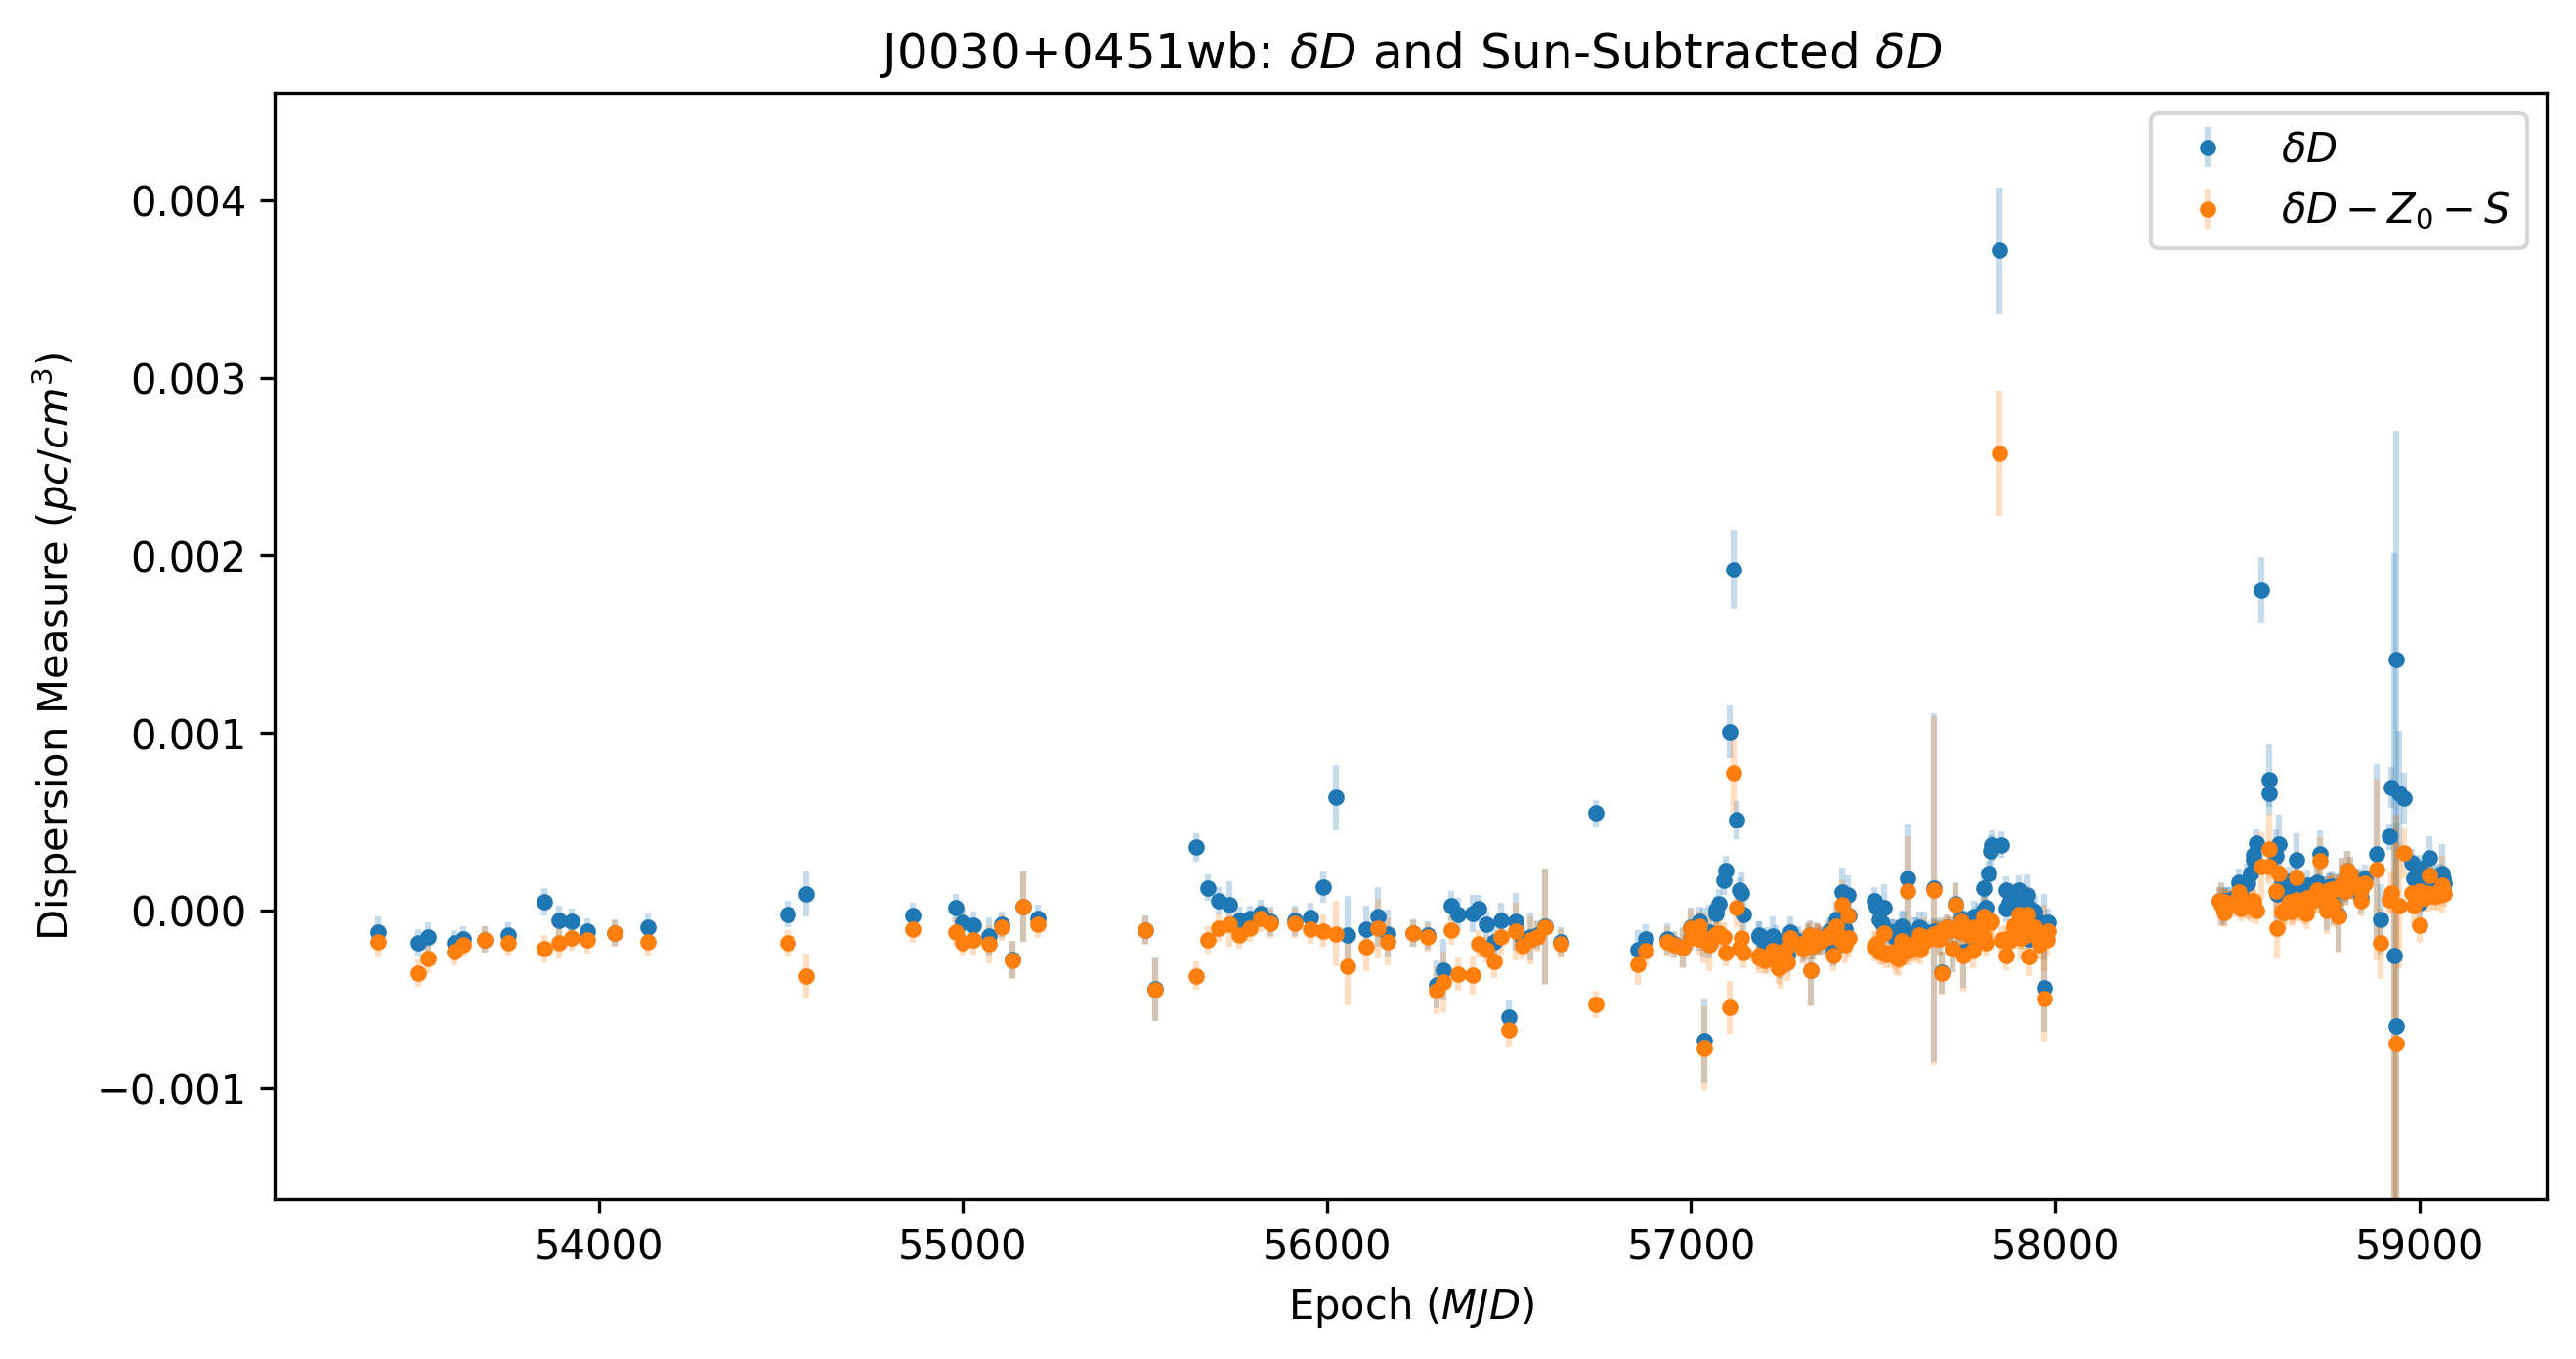

In [100]:
#unfold the fit
Z0Comp = 7.9*Z0(Time(daysSince1Jan + 55197, format='mjd'), p1)
SinusoidComp = popt[0]*np.sin(2*np.pi*(daysSince1Jan-popt[1])/365)

DMXminusZ0S = p1.DMX_ARR - Z0Comp - SinusoidComp #this is the sun-subtracted data!

#plot solar wind-removed data against normal
markers, caps, bars = plt.errorbar(p1.DMXEP_ARR, p1.DMX_ARR, p1.DMX_ERROR_ARR, fmt=".") #plot original dD data
[bar.set_alpha(0.25) for bar in bars]
markers, caps, bars = plt.errorbar(p1.DMXEP_ARR, DMXminusZ0S, p1.DMX_ERROR_ARR, fmt=".") #plot sun-subtracted dD data
[bar.set_alpha(0.25) for bar in bars]
diff = p1.DMX_ARR.max() - p1.DMX_ARR.min()
plt.ylim([p1.DMX_ARR.min() - 0.2*diff, p1.DMX_ARR.max() + 0.2*diff])
plt.ylabel(r"Dispersion Measure $(pc/cm^3)$")
plt.xlabel(r"Epoch $(MJD)$")
plt.title(p1.PSR + ("nb" if narrowband else "wb") +r": $\delta D$ and Sun-Subtracted $\delta D$")
plt.legend([r"$\delta D$",r"$\delta D-Z_0-S$"])
plt.show()

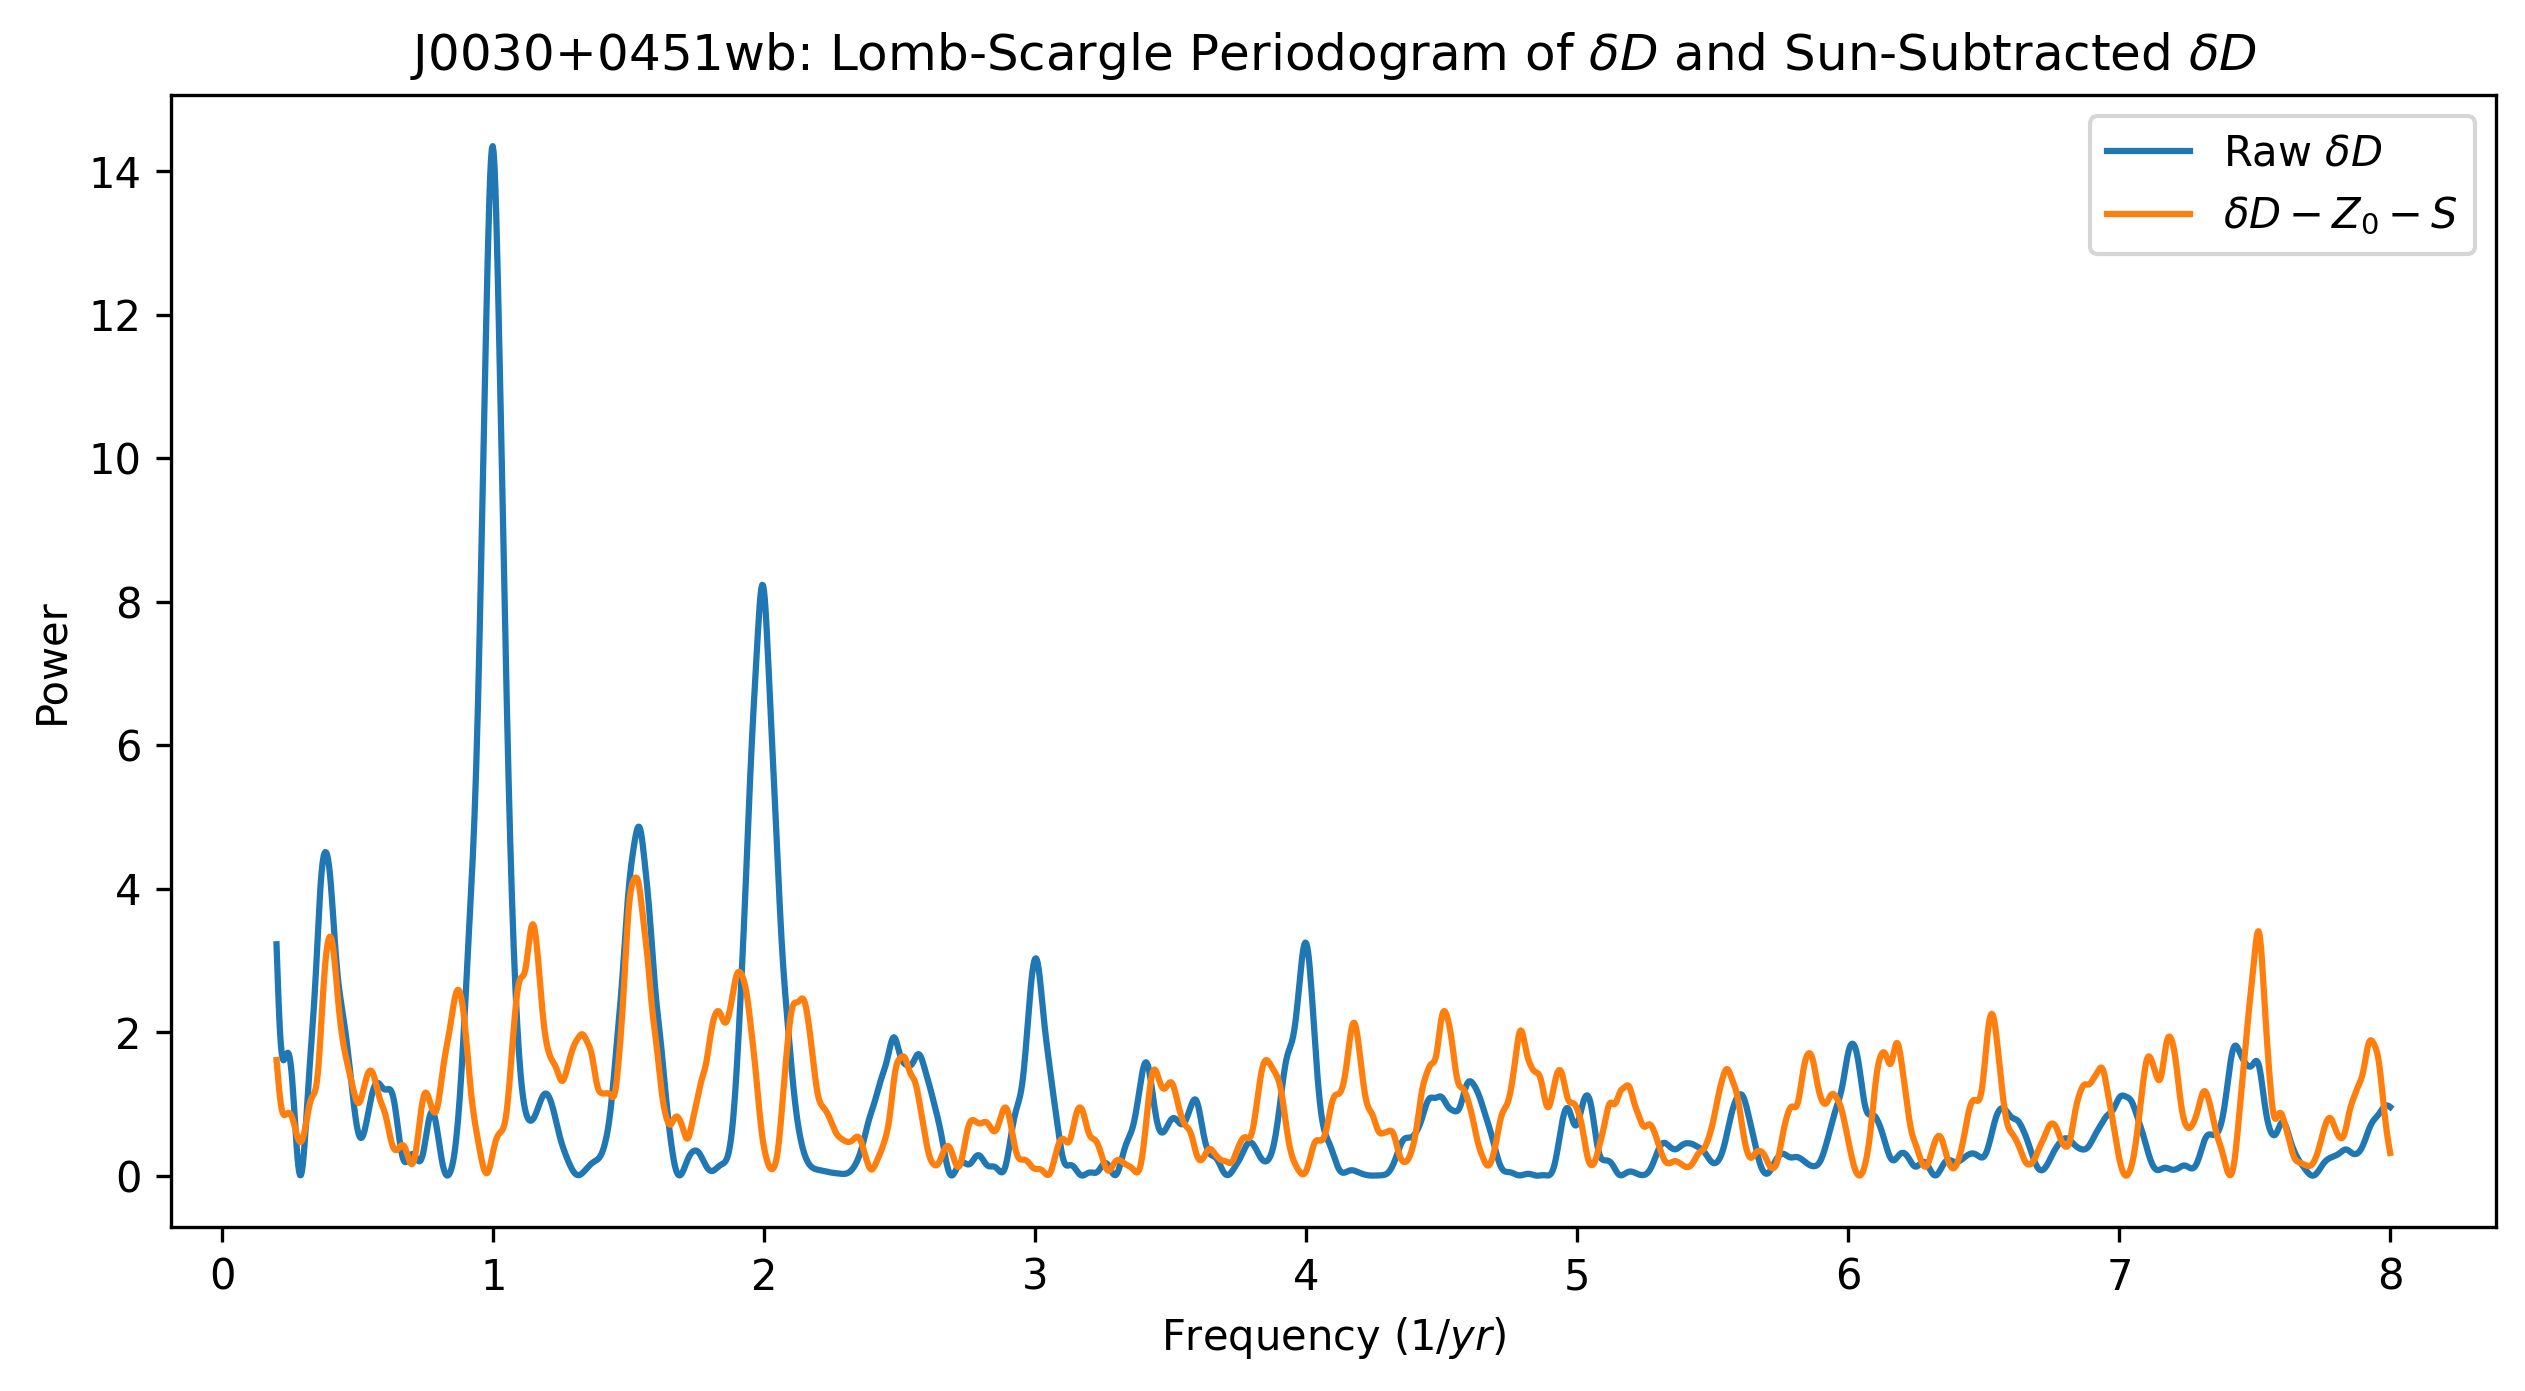

In [101]:
#apply LombScargle Periodogram
DMXEPyr = p1.DMXEP_ARR/365 #change to units of yr
freq, p_ls = LombScargle(DMXEPyr, p1.DMX_ARR).autopower(minimum_frequency=0.2, maximum_frequency=8, normalization='psd', samples_per_peak=20) #original dD
freq2, p_ls2 = LombScargle(DMXEPyr, DMXminusZ0S).autopower(minimum_frequency=0.2, maximum_frequency=8, normalization='psd', samples_per_peak=20) #sun-subtracted dD
p_ls /= np.average(p_ls)
p_ls2 /= np.average(p_ls2)
#ideally, the powers of 1/yr should be significantly reduced.

#plot periodogram
plt.plot(freq, p_ls)
plt.plot(freq2, p_ls2)
plt.xlabel(r"Frequency $(1/yr)$")
plt.ylabel("Power")
plt.legend([r"Raw $\delta D$",r"$\delta D-Z_0-S$"])
plt.title(p1.PSR + ("nb" if narrowband else "wb") + r": Lomb-Scargle Periodogram of $\delta D$ and Sun-Subtracted $\delta D$")
plt.show()

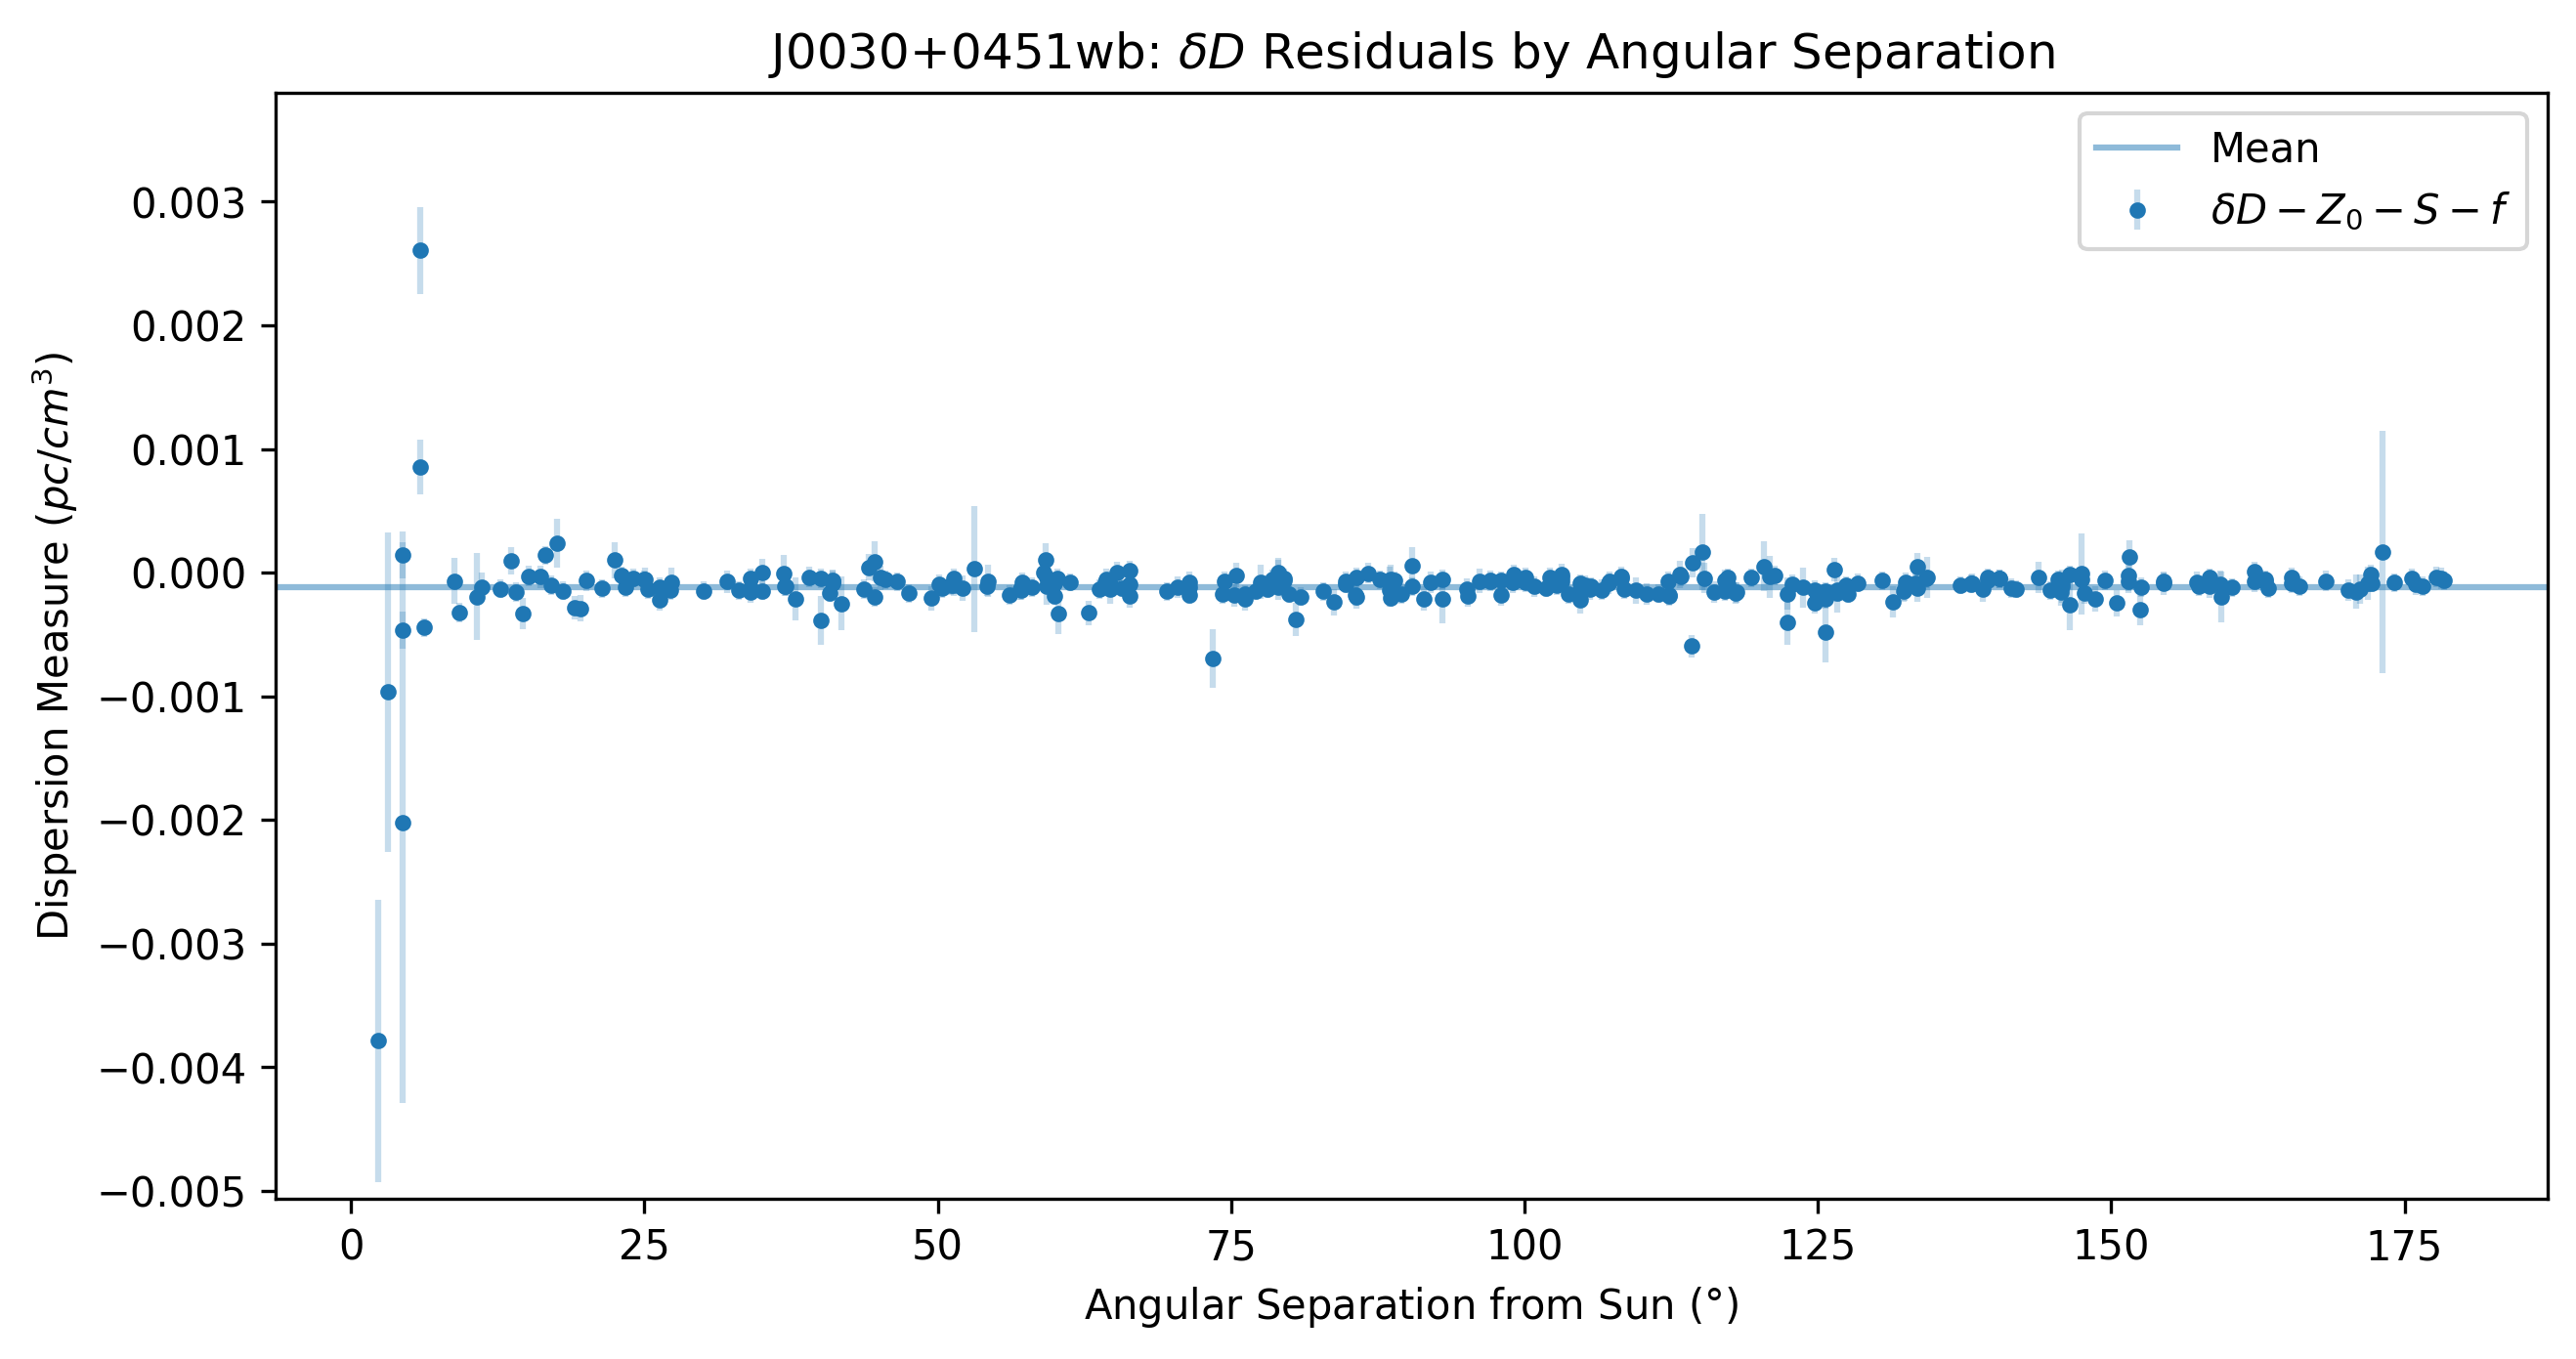

In [102]:
#Subtract initial 3rd-Order Polynomial, so that (ideally) everything would be 0, plot the actual residuals
DMXadj = (DMXminusZ0S-polyfit)
sortedDMXadj = DMXadj[orderedIndices] #sort by angle
markers, caps, bars = plt.errorbar(theta1*180/np.pi, sortedDMXadj, sortedDMX_ERROR, fmt=".")
[bar.set_alpha(0.25) for bar in bars]
diff = DMXadj.max() - DMXadj.min()
mean = np.mean(sortedDMXadj)
plt.axhline(mean, alpha=0.5) #show the mean as a horizontal line
plt.ylim([DMXadj.min() - 0.2*diff, DMXadj.max() + 0.2*diff])
plt.ylabel(r"Dispersion Measure $(pc/cm^3)$")
plt.xlabel(r"Angular Separation from Sun $(\degree)$")
plt.legend([r"Mean", r"$\delta D-Z_0-S-f$"])
plt.title(p1.PSR + ("nb" if narrowband else "wb") +r": $\delta D$ Residuals by Angular Separation")
plt.show()

angsepresidx = theta1*180/np.pi #store the data for the all-pulsar plot
angsepresidy = sortedDMXadj
angsepreside = sortedDMX_ERROR
residras = pulsar_ras
residdecs = pulsar_decs

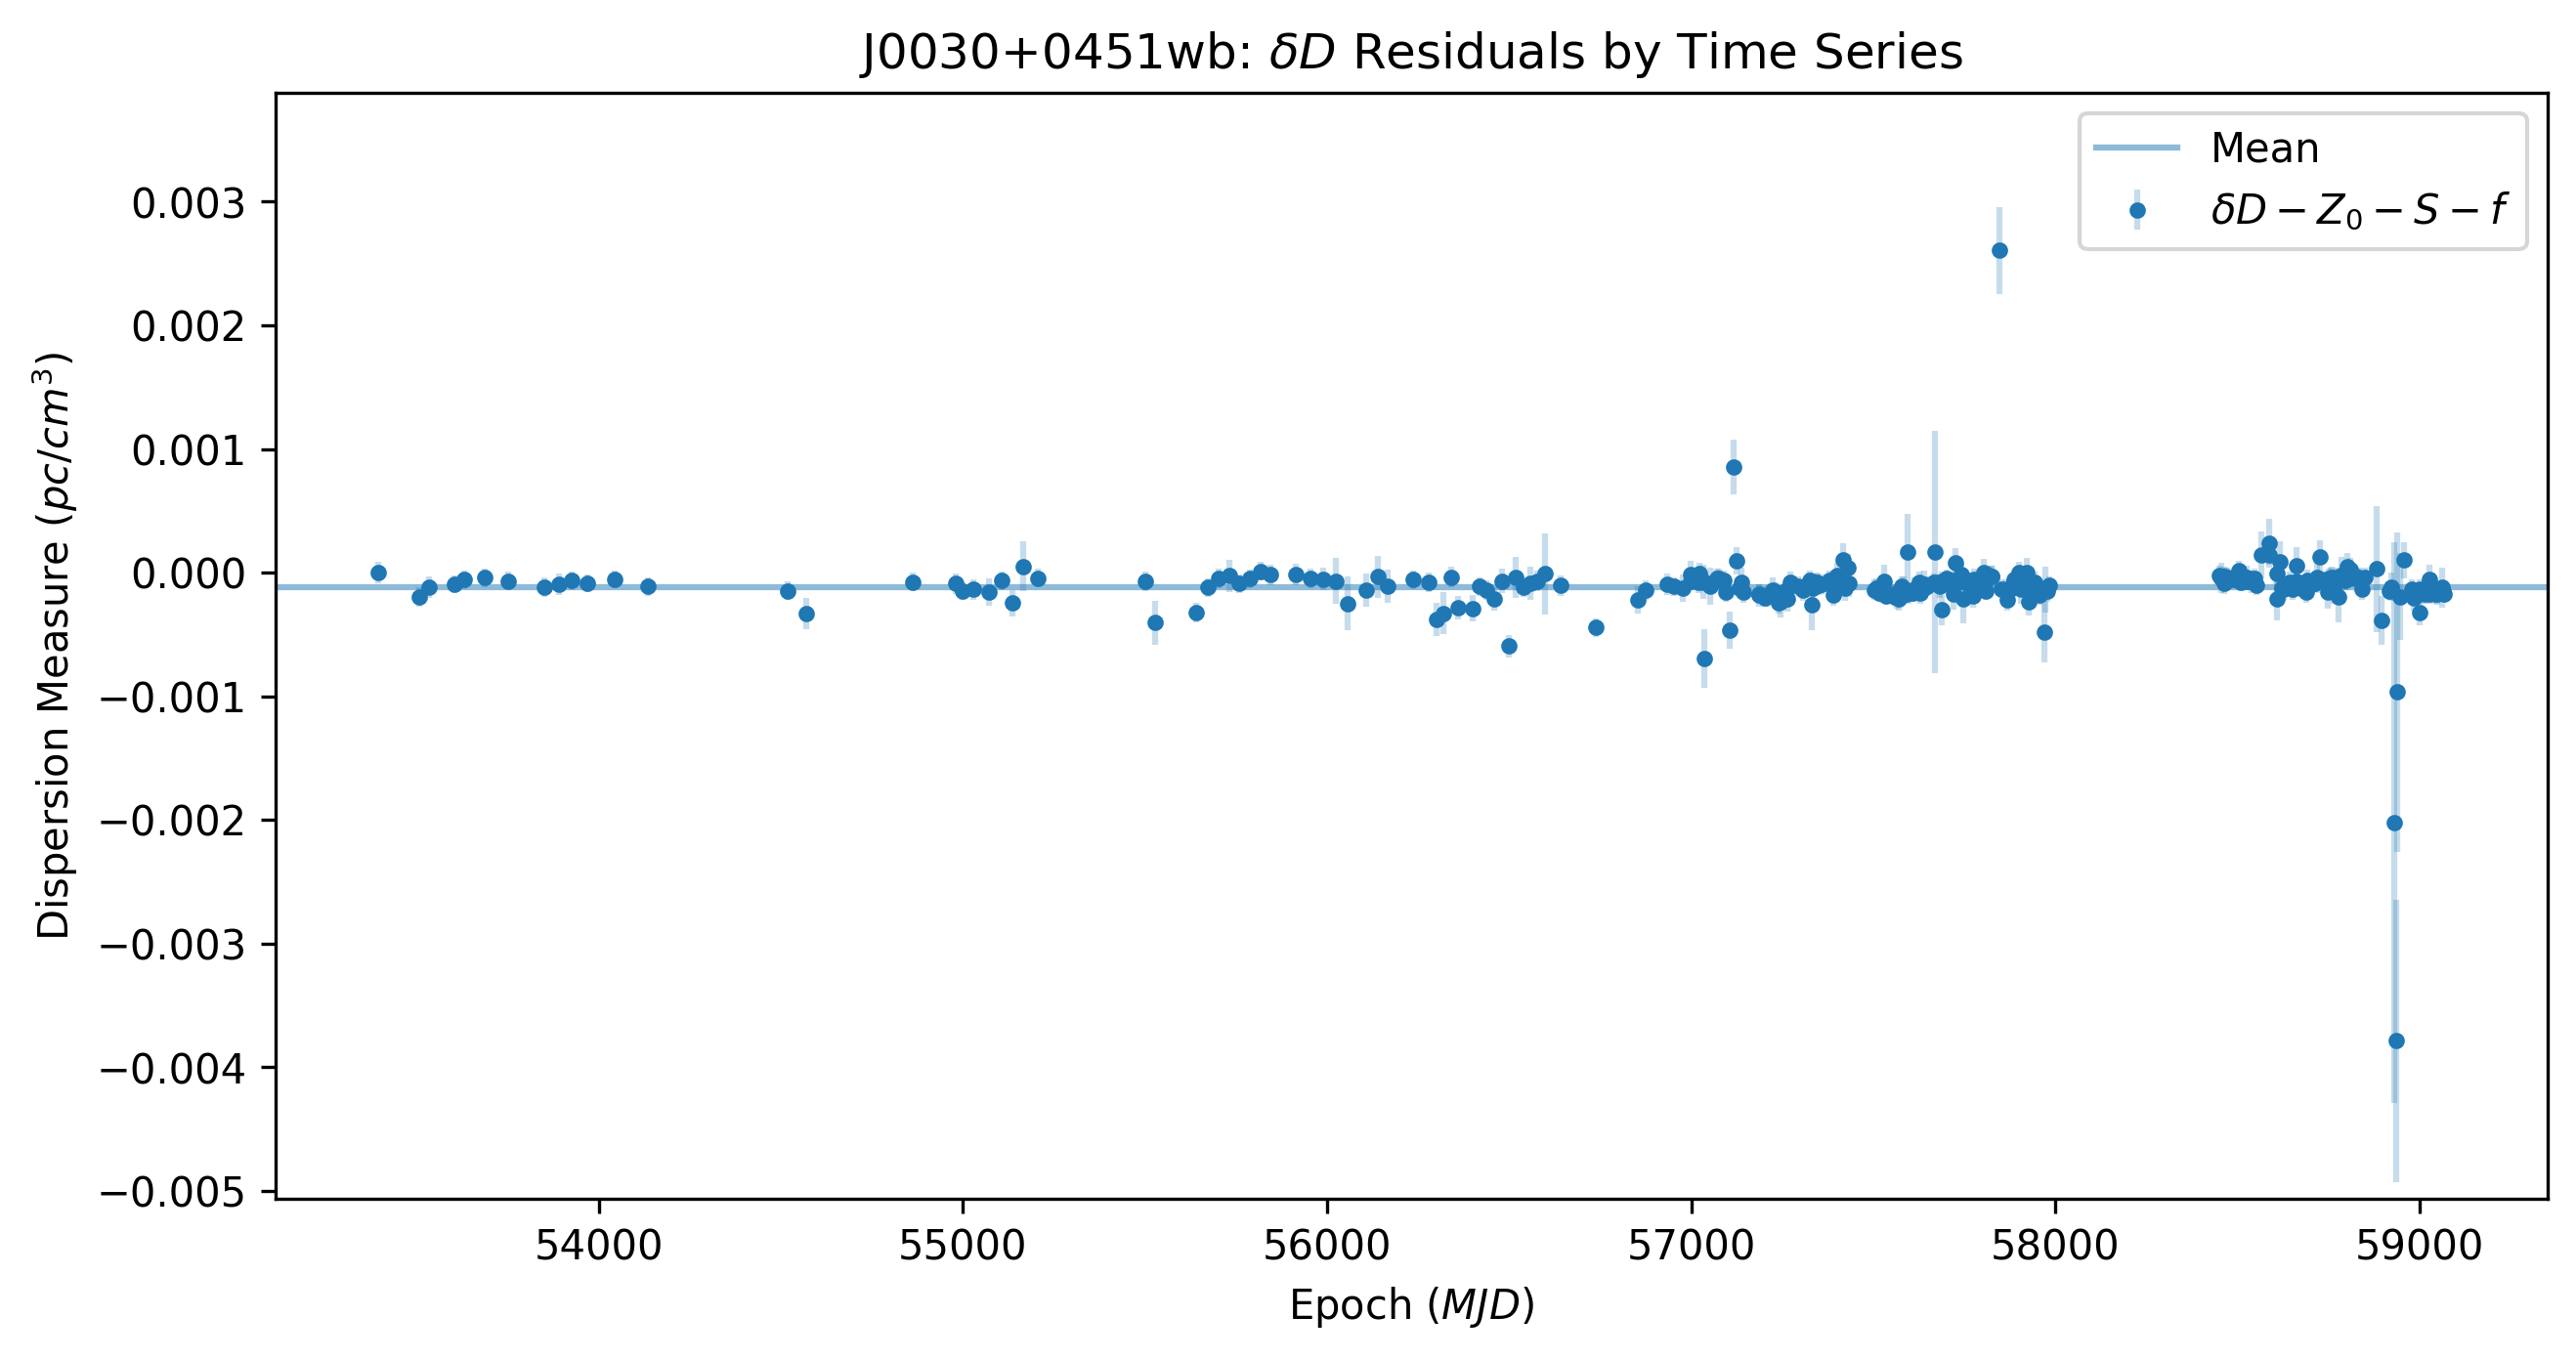

In [103]:
#same as previous plot, but by time series instead of angular separation
markers, caps, bars = plt.errorbar(p1.DMXEP_ARR, DMXadj, p1.DMX_ERROR_ARR, fmt=".")
[bar.set_alpha(0.25) for bar in bars]
plt.axhline(mean, alpha=0.5) #show the mean as a horizontal line
plt.ylim([DMXadj.min() - 0.2*diff, DMXadj.max() + 0.2*diff])
plt.ylabel(r"Dispersion Measure $(pc/cm^3)$")
plt.xlabel(r"Epoch $(MJD)$")
plt.legend([r"Mean", r"$\delta D-Z_0-S-f$"])
plt.title(p1.PSR + ("nb" if narrowband else "wb") +r": $\delta D$ Residuals by Time Series")
plt.show()

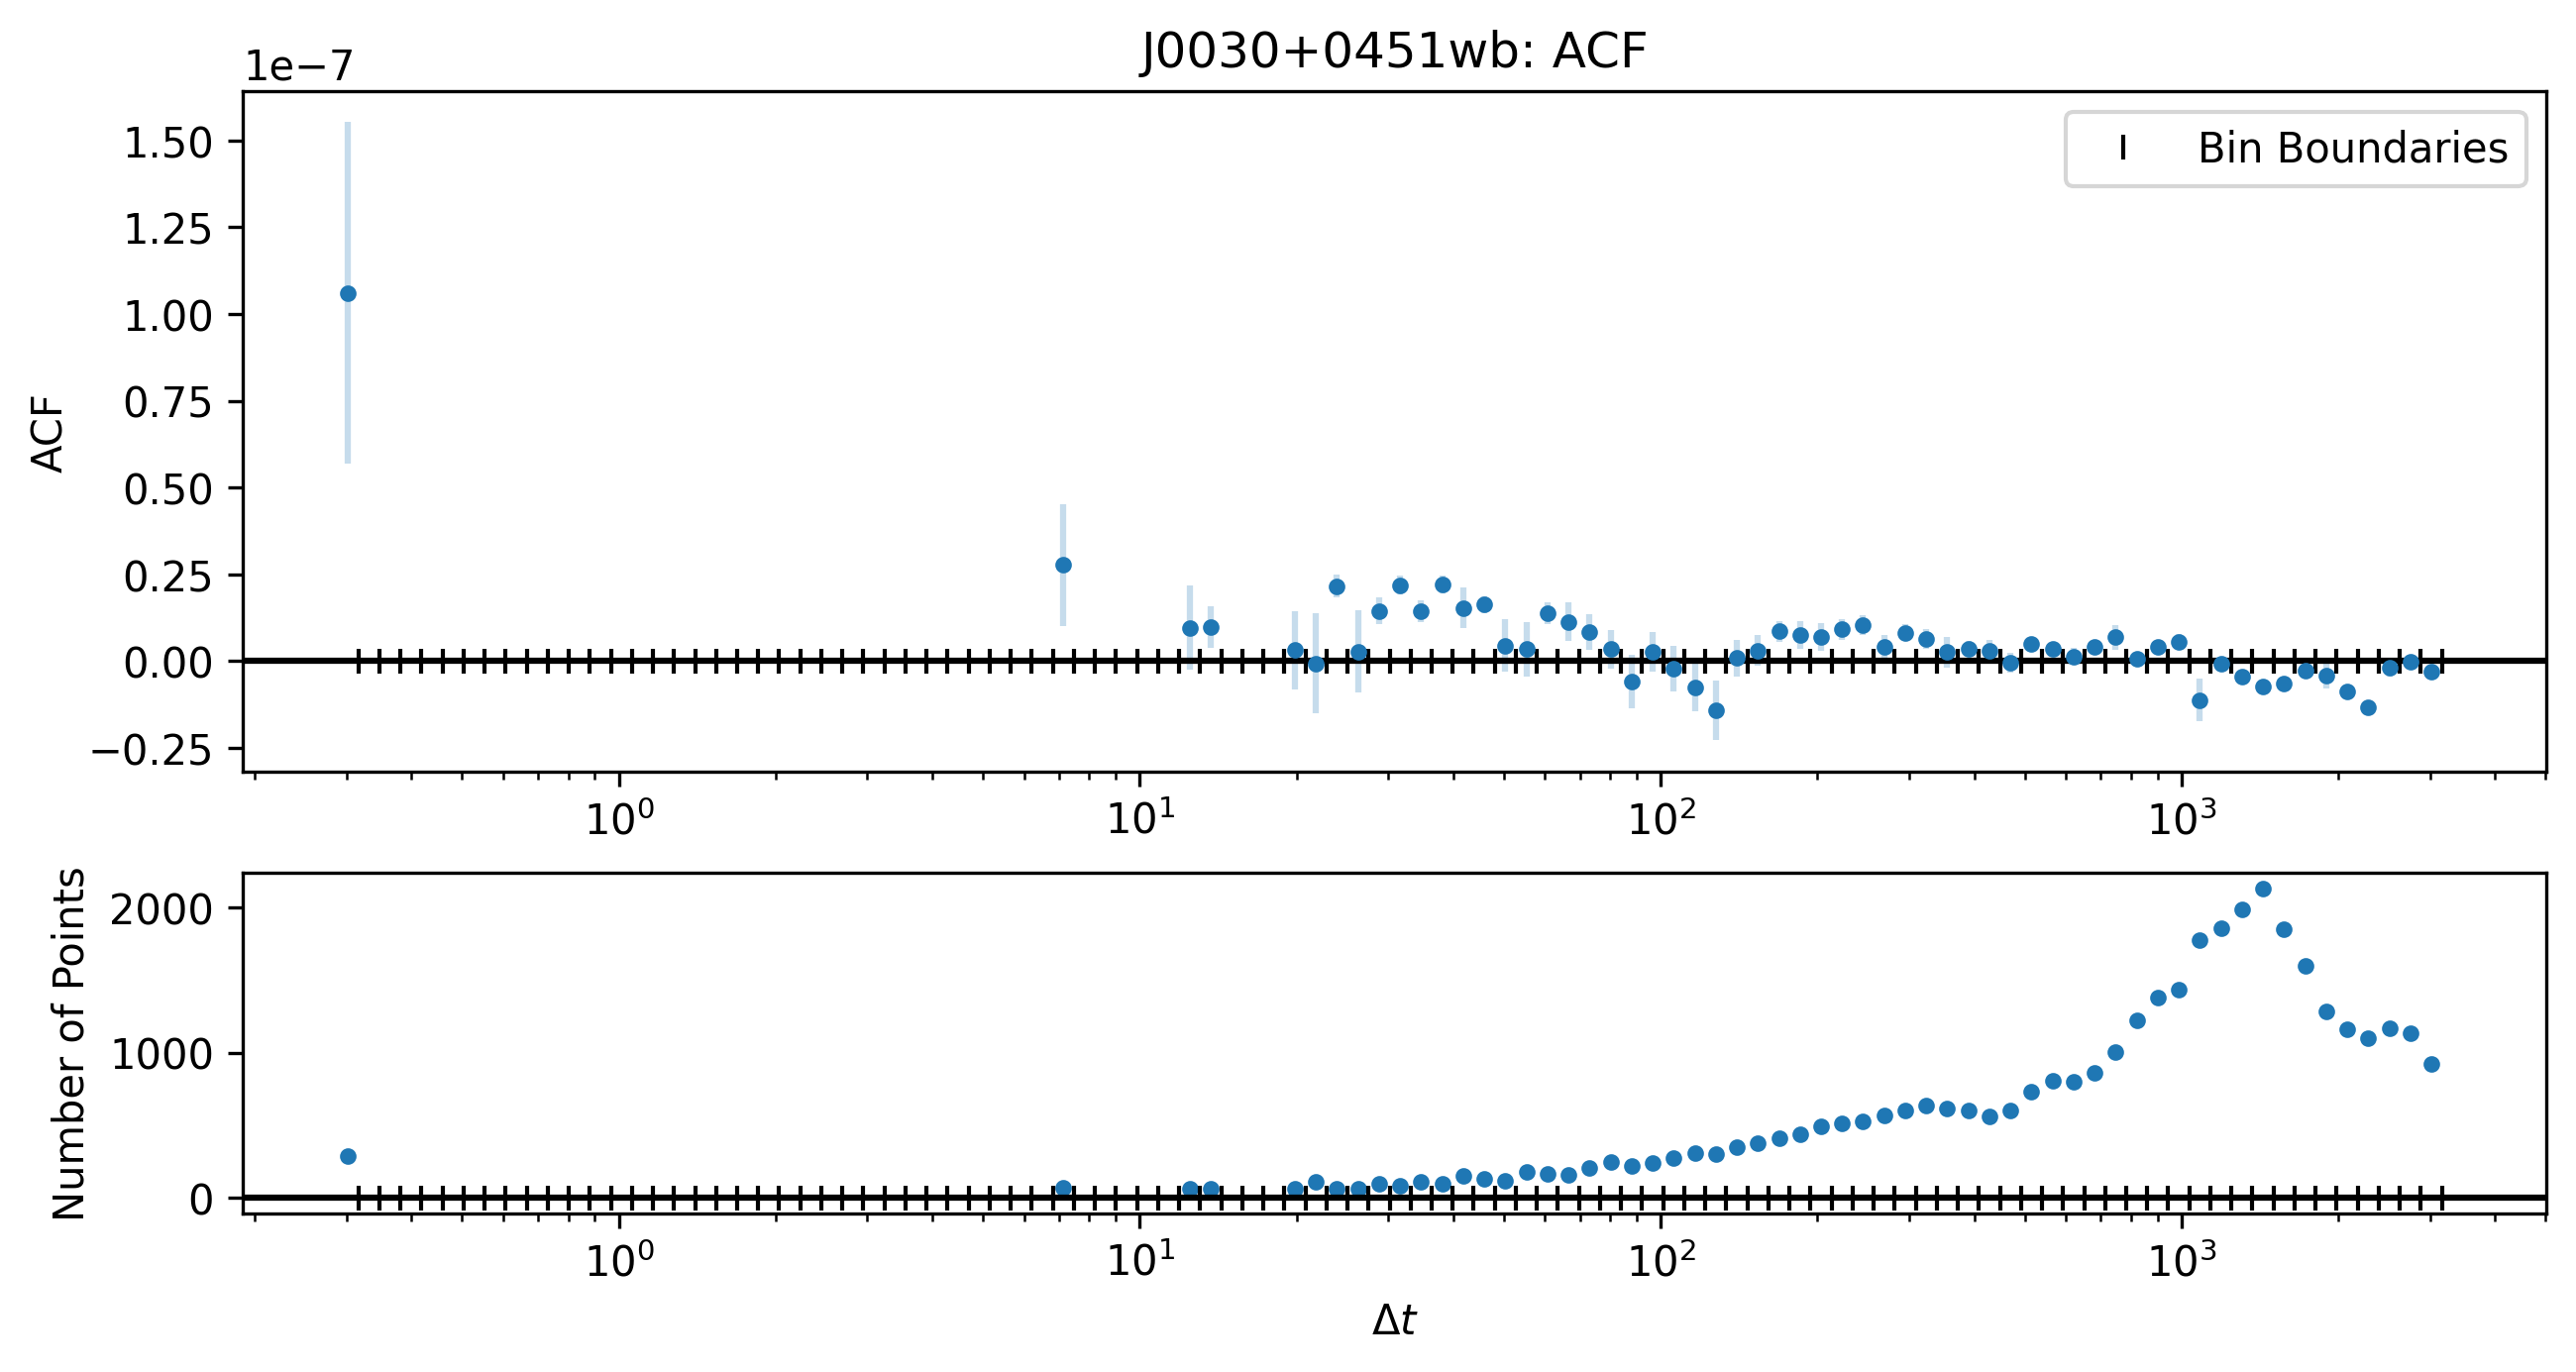

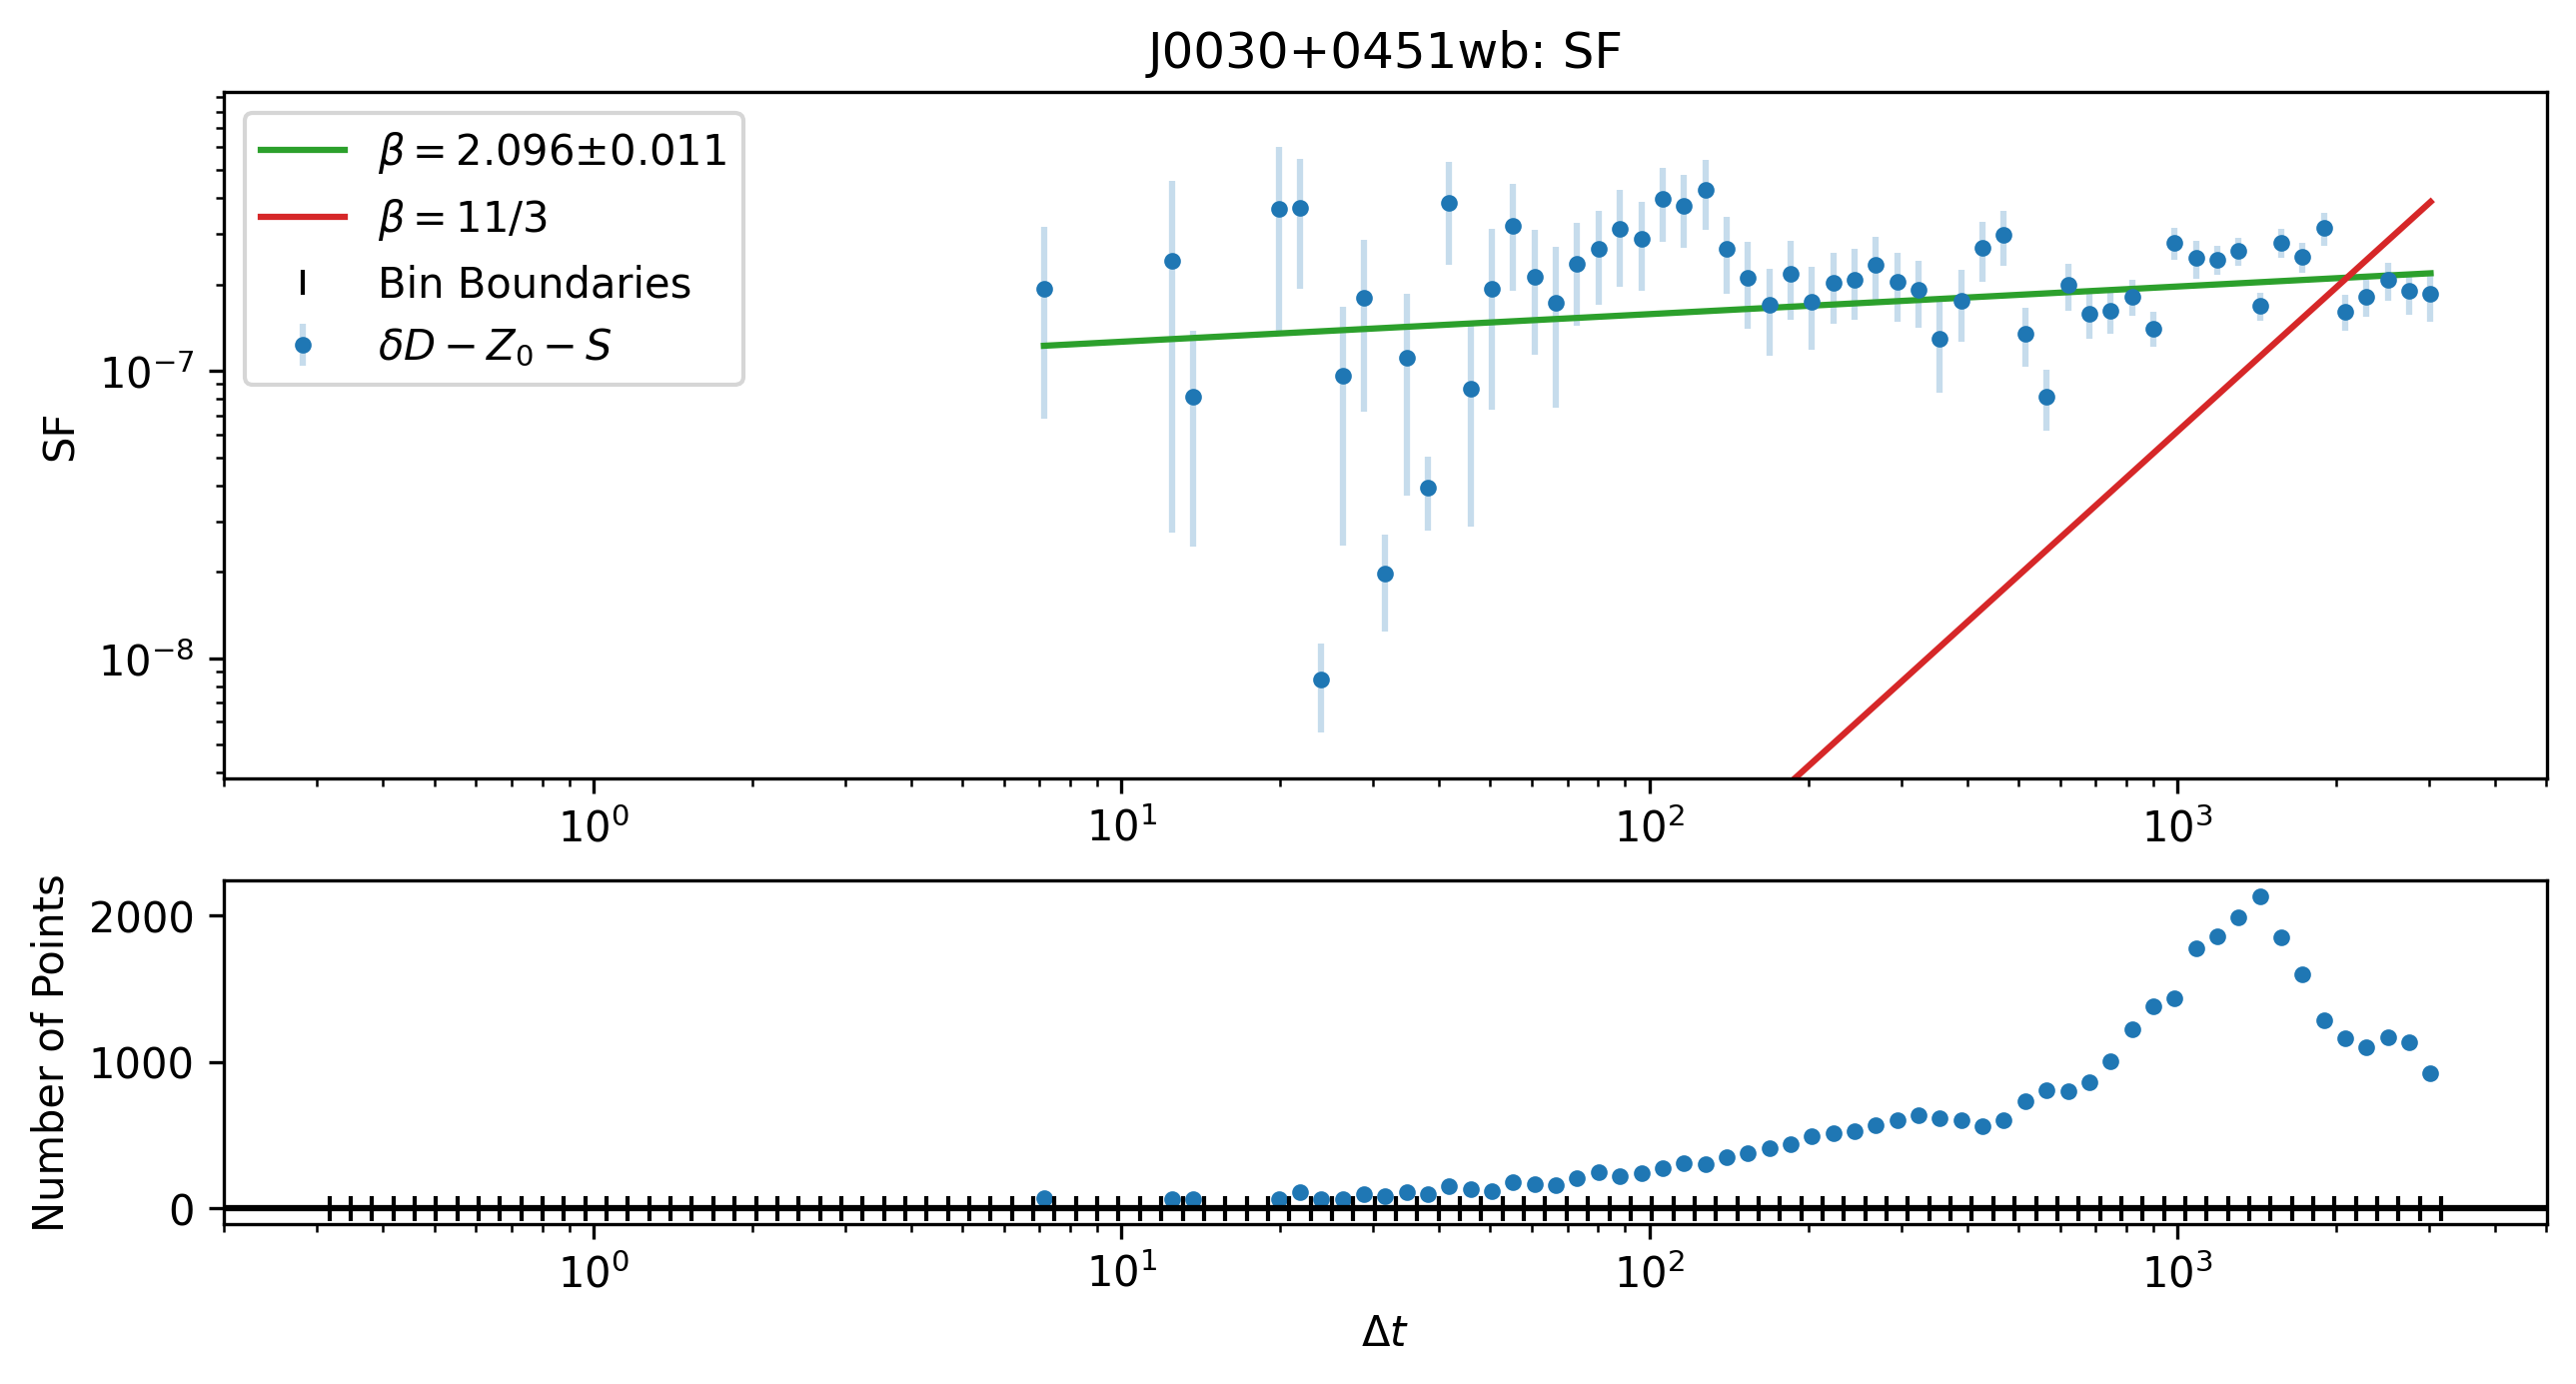

In [104]:
#plot ACF and SF
times = p1.DMXEP_ARR
mu = np.average(DMXminusZ0S) #need to adjust for the mean
n = len(times)
Dt = np.zeros(int(n*((n+1)/2))) #because uneven sampling, use Delta ts, and the Delta ts will be for each pair of data points (n*(n+1)/2 for no repeating pairs) 
acfp = np.zeros(len(Dt)) #initialize acf "prime", where it will not be averaged across the bin
sfp = np.zeros(len(Dt)) #ditto for sf "prime"
k = 0
for i in range(n):
    for j in range(n):
        if j > i: continue #only want each combo of points once
        Dt[k] = times[i] - times[j] #calculate Delta t
        acfp[k] = (DMXminusZ0S[i]-mu)*(DMXminusZ0S[j]-mu) #calculate acf for each Dt
        sfp[k] = (DMXminusZ0S[i]-DMXminusZ0S[j])**2 #calculate sf for each Dt
        k += 1

binsp = np.linspace(-0.5, 3.5, 100) #create the bins, bins "prime" is the exponent of the log bins
binw = binsp[1] - binsp[0] #bin "width" -- bins are logarithmically sized
bins = 10**binsp #create log bins
acf = np.zeros(len(bins)+1) #initialize new vars to average across each bin
sf = np.zeros(len(bins)+1)
nums = np.zeros(len(bins)+1)
stdv = [[] for _ in range(len(bins) + 1)]
stdv2 = [[] for _ in range(len(bins) + 1)]

binindex = np.digitize(Dt, bins, right=True) #create the bins: note that digitize adds a bin on the right, and we ignore that bin, hence all the [:-1] later

for i in range(len(binindex)): #bin everything
    acf[binindex[i]] += acfp[i] #note that this is summing across the bin, division by the number for the average will be done later
    sf[binindex[i]] += sfp[i]
    stdv[binindex[i]].append(acfp[i]) #append value to list, where the standard deviation will be calculated later
    stdv2[binindex[i]].append(sfp[i]) #"2" in this context means sf instead of acf
    nums[binindex[i]] += 1

stdv = np.array([(np.std(stdv[i]) if stdv[i] else 0) for i in range(len(bins) + 1)]) #calculate the standard deviation across each bin
stdv2 = np.array([(np.std(stdv2[i]) if stdv2[i] else 0) for i in range(len(bins) + 1)])

minpoints = 50 #minimum threshold for points in a bin, to counteract small-number statistics
acf = acf[:-1][nums[:-1] > minpoints] #filter out bins that do not meet the threshold
sf = sf[:-1][nums[:-1] > minpoints]
x_bins = 10**(binsp - binw/2)[nums[:-1] > minpoints]
x_bins2 = 10**(binsp - binw/2)[nums[:-1] > minpoints]
stdv = stdv[:-1][nums[:-1] > minpoints]
stdv2 = stdv2[:-1][nums[:-1] > minpoints]
nums = nums[:-1][nums[:-1] > minpoints]
stdv /= np.sqrt(nums) #calculate standard error
stdv2 /= np.sqrt(nums)
acf /= nums #divide by number in each bin, creating the mean
sf /= nums
stdv2 = stdv2[1:] #remove the 0th bin for the sf, as that will be zero, and will not play nicely with the log-log plot
sf = sf[1:]
x_bins2 = x_bins2[1:]


if len(sf) > 10: #if there are an adequate number of bins left (many of the recent pulsars will not have enough data to be meaningful)

    #plot ACF and num of points
    gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) #subfigure: one to show acf, one to show number of points in bin
    fig = plt.figure()
    ax = fig.add_subplot(gs[0]) #first plot
    ax.set_title(p1.PSR + ("nb" if narrowband else "wb") +": ACF")
    markers, caps, bars = ax.errorbar(x_bins, acf, stdv, fmt=".")
    [bar.set_alpha(0.25) for bar in bars]
    ax.axhline(0, color="k")
    ax.set_xscale("log")
    ax.plot(bins, np.zeros(len(bins)), "k|", label="Bin Boundaries") #use the bin max values to create markers for bin boundaries
    ax.legend()
    ax.set_ylabel("ACF")
    ax = fig.add_subplot(gs[1], sharex=ax) #second plot
    ax.plot(x_bins, nums , ".")
    ax.axhline(0, color="k")
    ax.plot(bins, np.zeros(len(bins)), "k|") #use the bin max values to create markers for bin boundaries
    ax.set_ylabel("Number of Points")
    ax.set_xlabel(r"$\Delta t$")
    plt.show()
    

    #plot SF and num of points
    gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) #same setup as ACF
    fig = plt.figure()
    ax = fig.add_subplot(gs[0])
    ax.set_title(p1.PSR + ("nb" if narrowband else "wb") +": SF")
    markers, caps, bars = ax.errorbar(x_bins2, sf, stdv2, fmt=".", label=r"$\delta D-Z_0-S$")
    [bar.set_alpha(0.25) for bar in bars]
    max = np.log10(sf.max())
    min = np.log10(sf.min())
    diff = max - min
    ax.set_ylim([10**(min - 0.2*diff), 10**(max + 0.2*diff)])

    try: #attempt to create a powerlaw fit
        max_ind = sf.argmax()
        if max_ind < len(sf)-1: max_ind += 1
        if len(sf[:max_ind]) < 8: raise RuntimeError
        log_sf = np.log10(sf)
        x = np.logspace(np.log10(x_bins2.min()), np.log10(x_bins2.max()), 10000) #create x-axis for the fit
        popt, pcov = curve_fit(expfit, x_bins2[:max_ind], sf[:max_ind], p0=[10**-8, 11/3, sf[0]*0.8], bounds=([0, 0, 0],[np.inf, np.inf, np.inf]), sigma=stdv2[:max_ind], maxfev=6400)
        errors = np.diag(pcov)
        #ax.plot(x, expfit(x, *popt), label=r"$\beta=$" + "{:.3f}".format(popt[1]) + r"$\pm$" + "{:.3f}".format(errors[1])) #plot the fit

        bool_vector = (x_bins2 > 365) & (x_bins2 < x_bins2[max_ind]) #only look at points between max and 365 days
        high_lag = np.where(bool_vector)
        if len(high_lag) < 3: #if the max occurs before 365, just use all after 365
            high_lag = np.where(x_bins2 > 365)
        log_xb2 =np.log10(x_bins2[high_lag]) #log-log space for linear fit
        log_sf = np.log10(sf[high_lag])
        log_x = np.log10(x)
        lin_fit, lin_cov = np.polyfit(log_xb2, log_sf, 1, cov=True) #perform linear fit
        lin_un = np.diag(lin_cov)
        ax.plot(x, 10**np.polyval(lin_fit, np.log10(x)), label=r"$\beta=$" + "{:.3f}".format(lin_fit[0]+2) + r"$\pm$" + "{:.3f}".format(lin_un[0]), color="tab:green") #plot the linear fit
        popt2, pcov2 = curve_fit(expfit2, x_bins2[high_lag], sf[high_lag], p0=[10**-8], bounds=([0],[np.inf]), sigma=stdv2[high_lag], maxfev=6400) #create the 11/3 fit, fit for horizontal placement
        ax.plot(x, expfit2(x, popt2), label=r"$\beta=11/3$", color="tab:red")


    except RuntimeError: #if optimal parameters not found, do not plot a fit
        print(p1.PSR + ("nb" if narrowband else "wb") + ": Optimal Parameters for Exponential Fit not found.")

    ax.axhline(0, color="k")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.plot(bins, np.zeros(len(bins)), "k|", label="Bin Boundaries") #use the bin max values to create markers for bin boundaries
    ax.legend()
    ax.set_ylabel("SF")
    ax = fig.add_subplot(gs[1], sharex=ax)
    ax.plot(x_bins2, nums[1:], ".")
    ax.axhline(0, color="k")
    ax.plot(bins, np.zeros(len(bins)), "k|") #use the bin max values to create markers for bin boundaries
    ax.set_ylabel("Number of Points")
    ax.set_xlabel(r"$\Delta t$")
    plt.show()

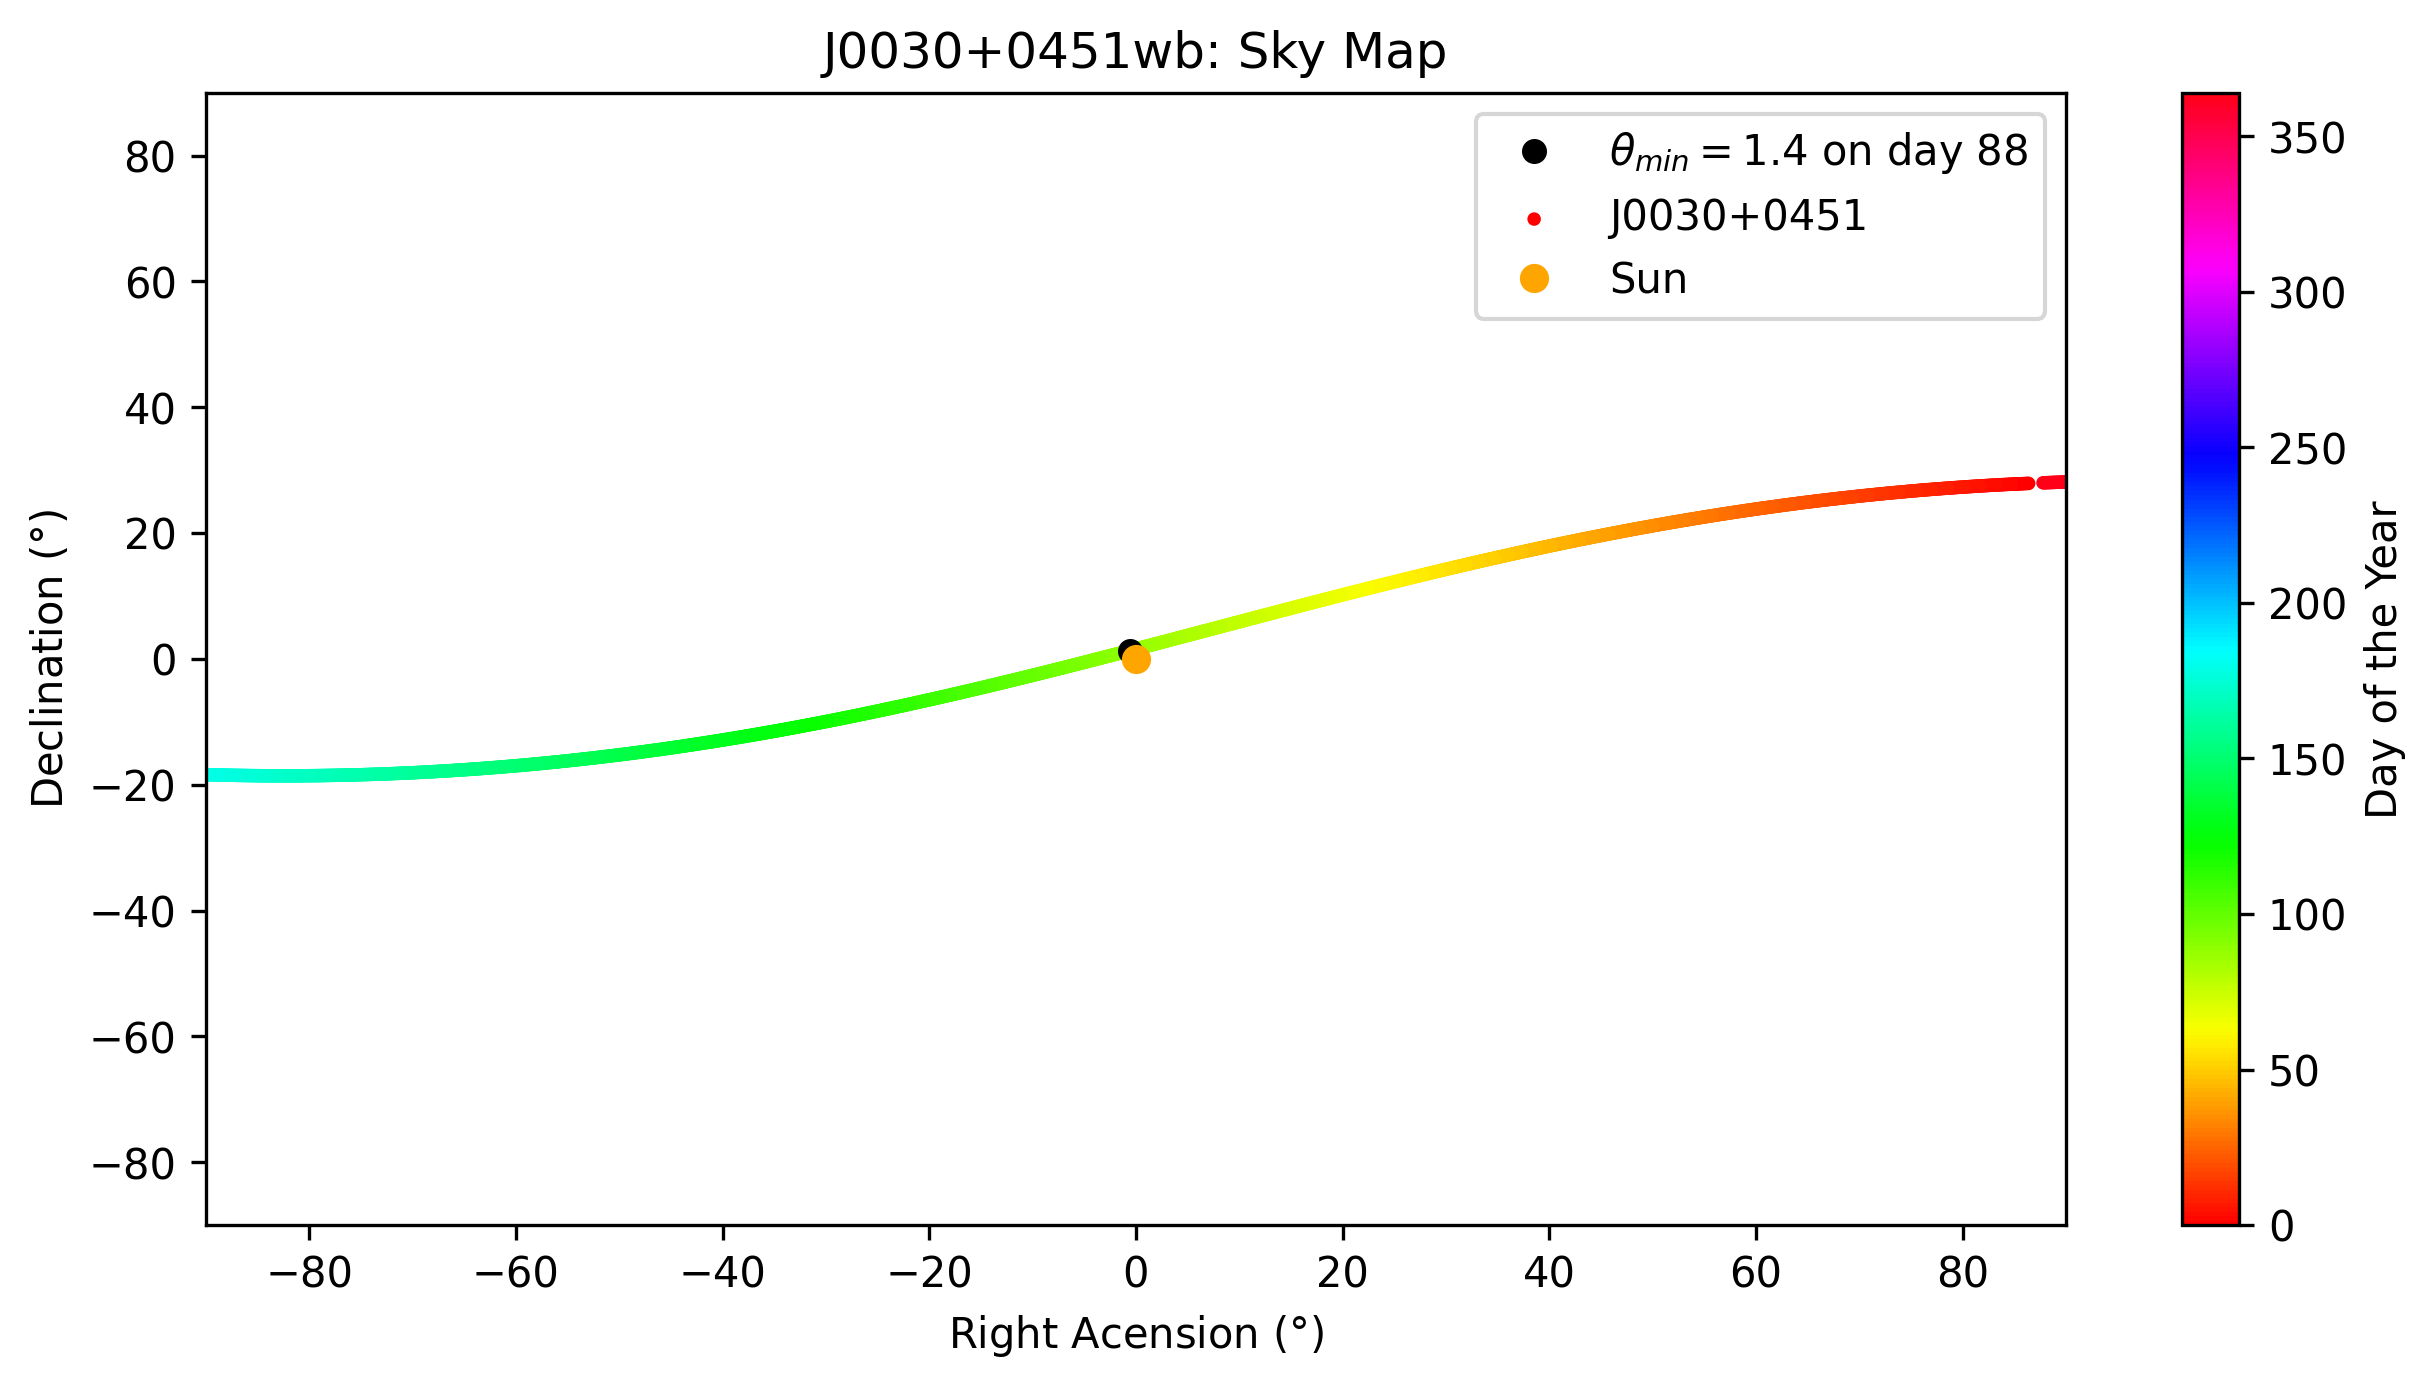

In [105]:
#create skymap
times = Time(np.linspace(55197, 55197+364, 3650), format='mjd')
skycoords = get_sun(times).gcrs
ras = pulsarSkyCoord.gcrs.ra.degree - skycoords.ra.degree
ras = np.mod(ras + 180, 360)-180
decs = pulsarSkyCoord.gcrs.dec.degree - skycoords.dec.degree
decs = np.mod(decs + 180, 360)-180
quadsum = np.sqrt(ras**2+decs**2)
plt.plot(ras[np.argmin(quadsum)], decs[np.argmin(quadsum)], "o", color='black', ms=5)
pl1 = plt.scatter(ras, decs, c=np.linspace(0, 364, 3650), cmap='hsv', s=5)
plt.plot(0, 0, "o", color='orange')
cb = plt.colorbar(pl1)
cb.set_label("Day of the Year")
plt.xlim([-90, 90])
plt.ylim([-90, 90])
plt.xlabel(r"Right Acension $(\degree)$")
plt.ylabel(r"Declination $(\degree)$")
plt.title(p1.PSR + ("nb" if narrowband else "wb") +": Sky Map")
plt.legend([r"$\theta_{min}=$" + "{:.1f}".format(quadsum[np.argmin(quadsum)]) + " on day " + "{:.0f}".format(np.linspace(0, 364, 3650)[np.argmin(quadsum)]), p1.PSR, "Sun"])
plt.show()

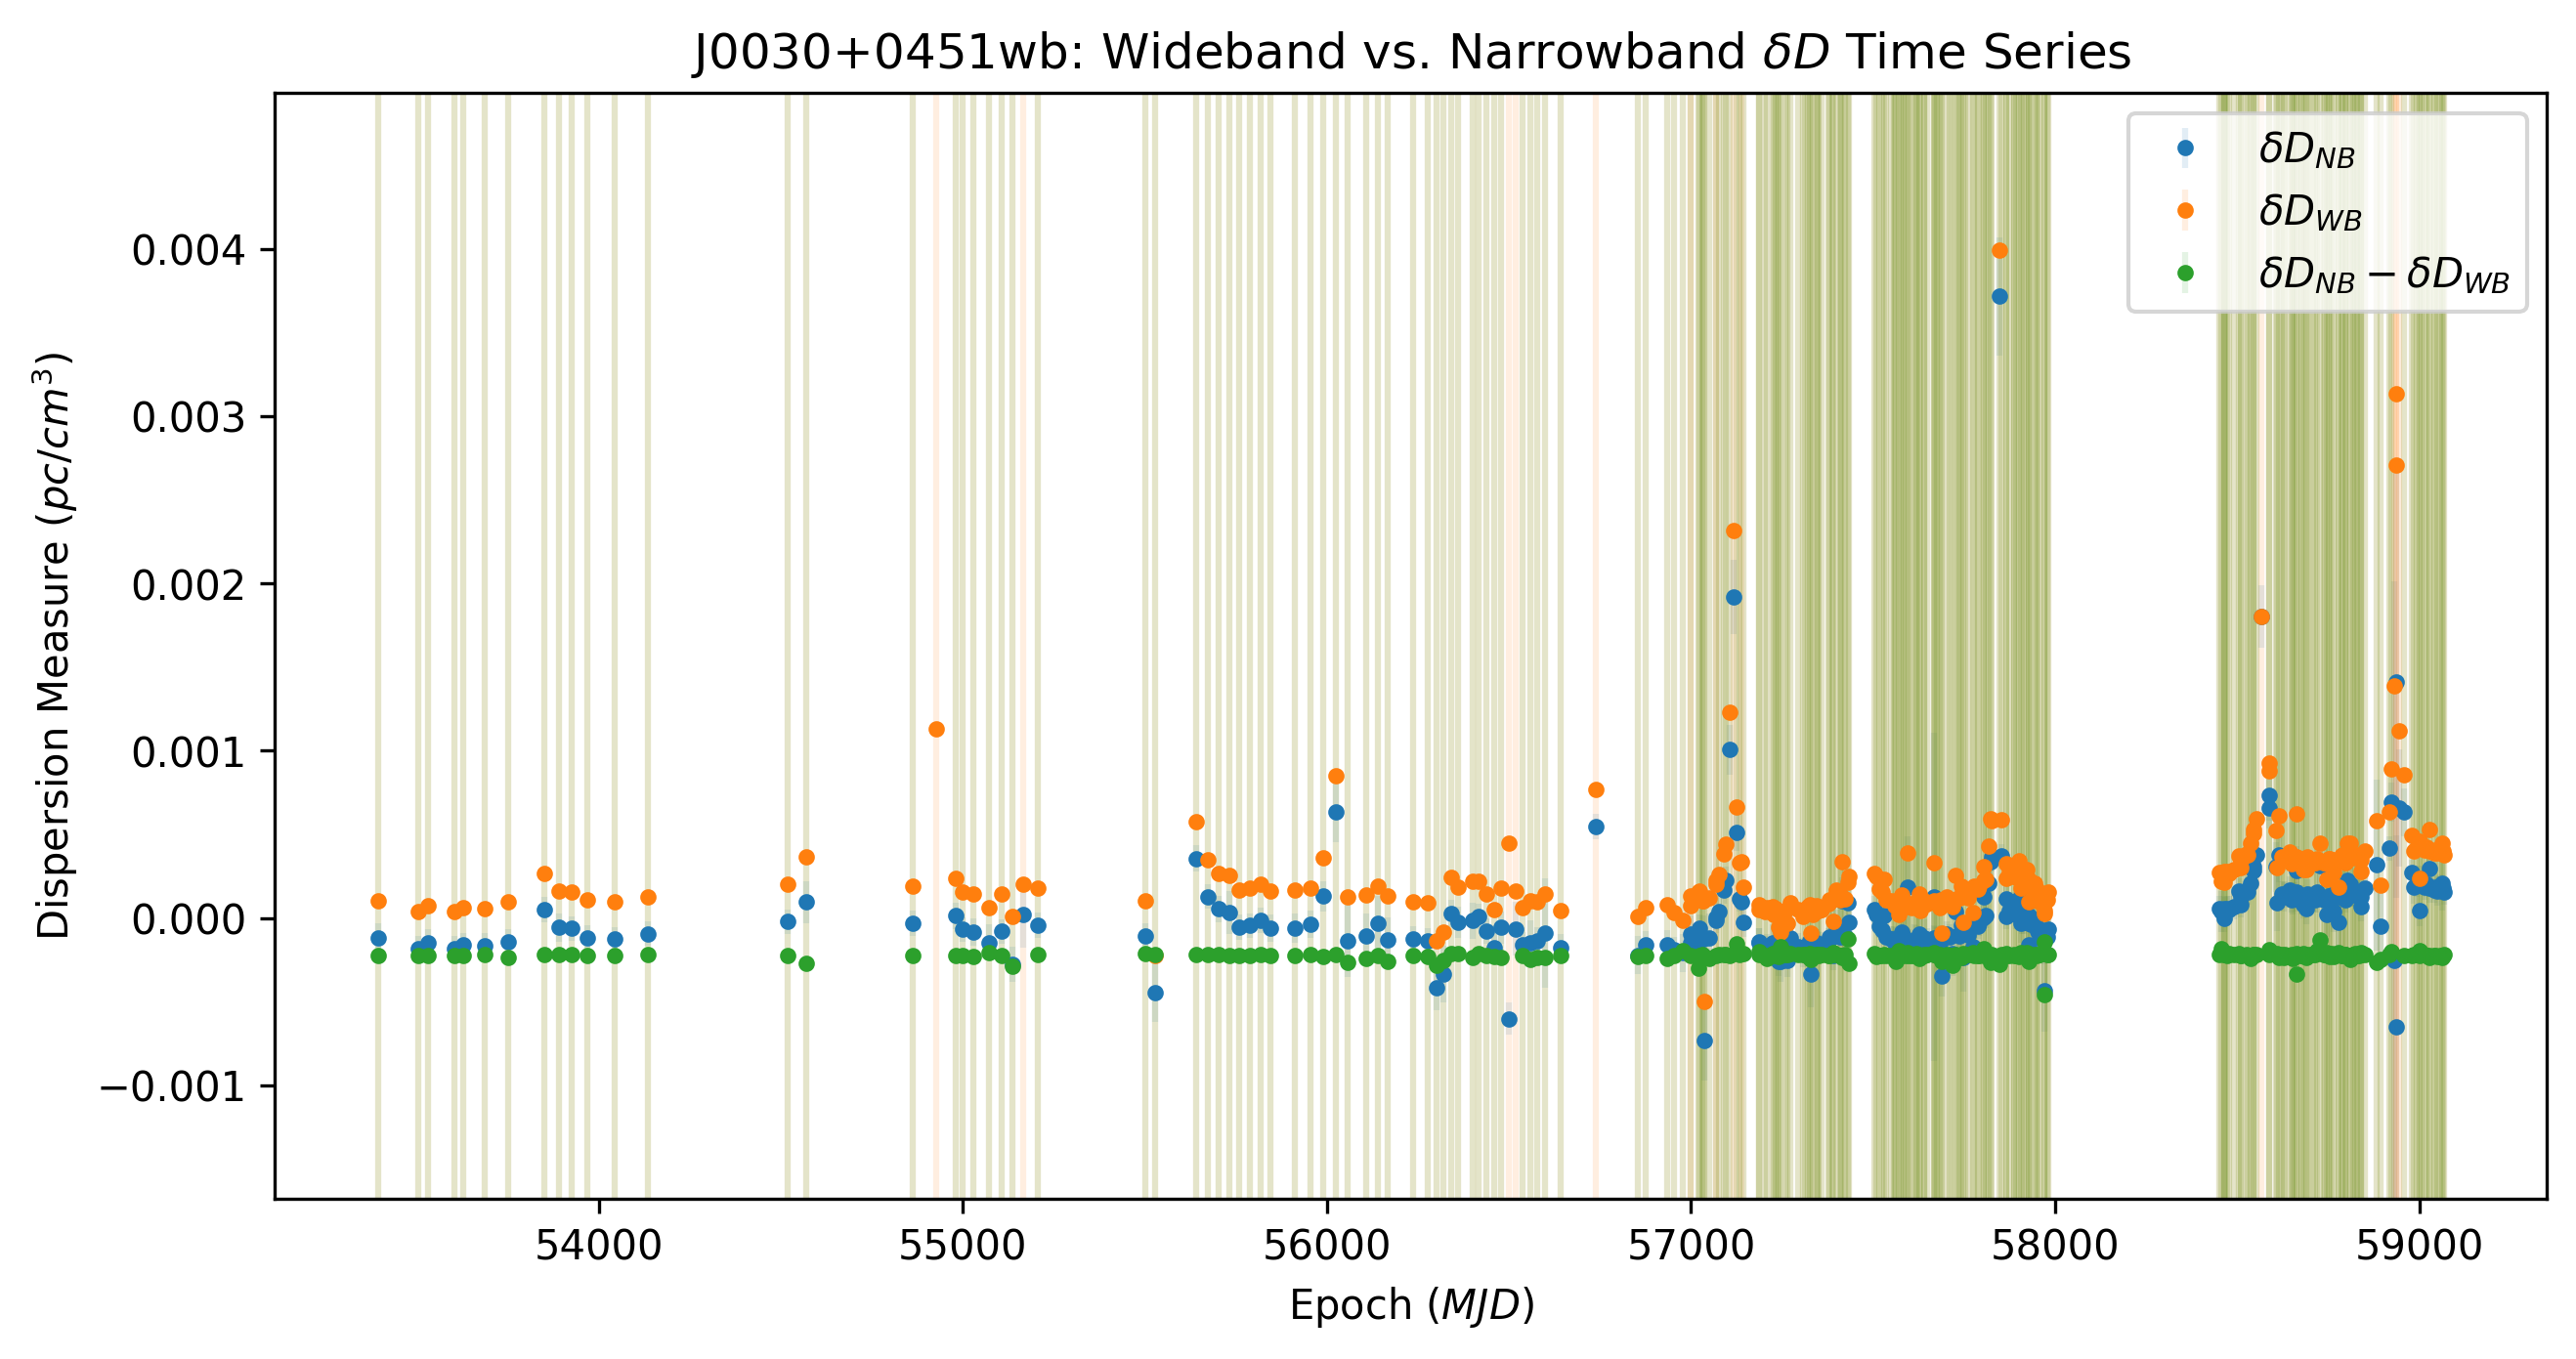

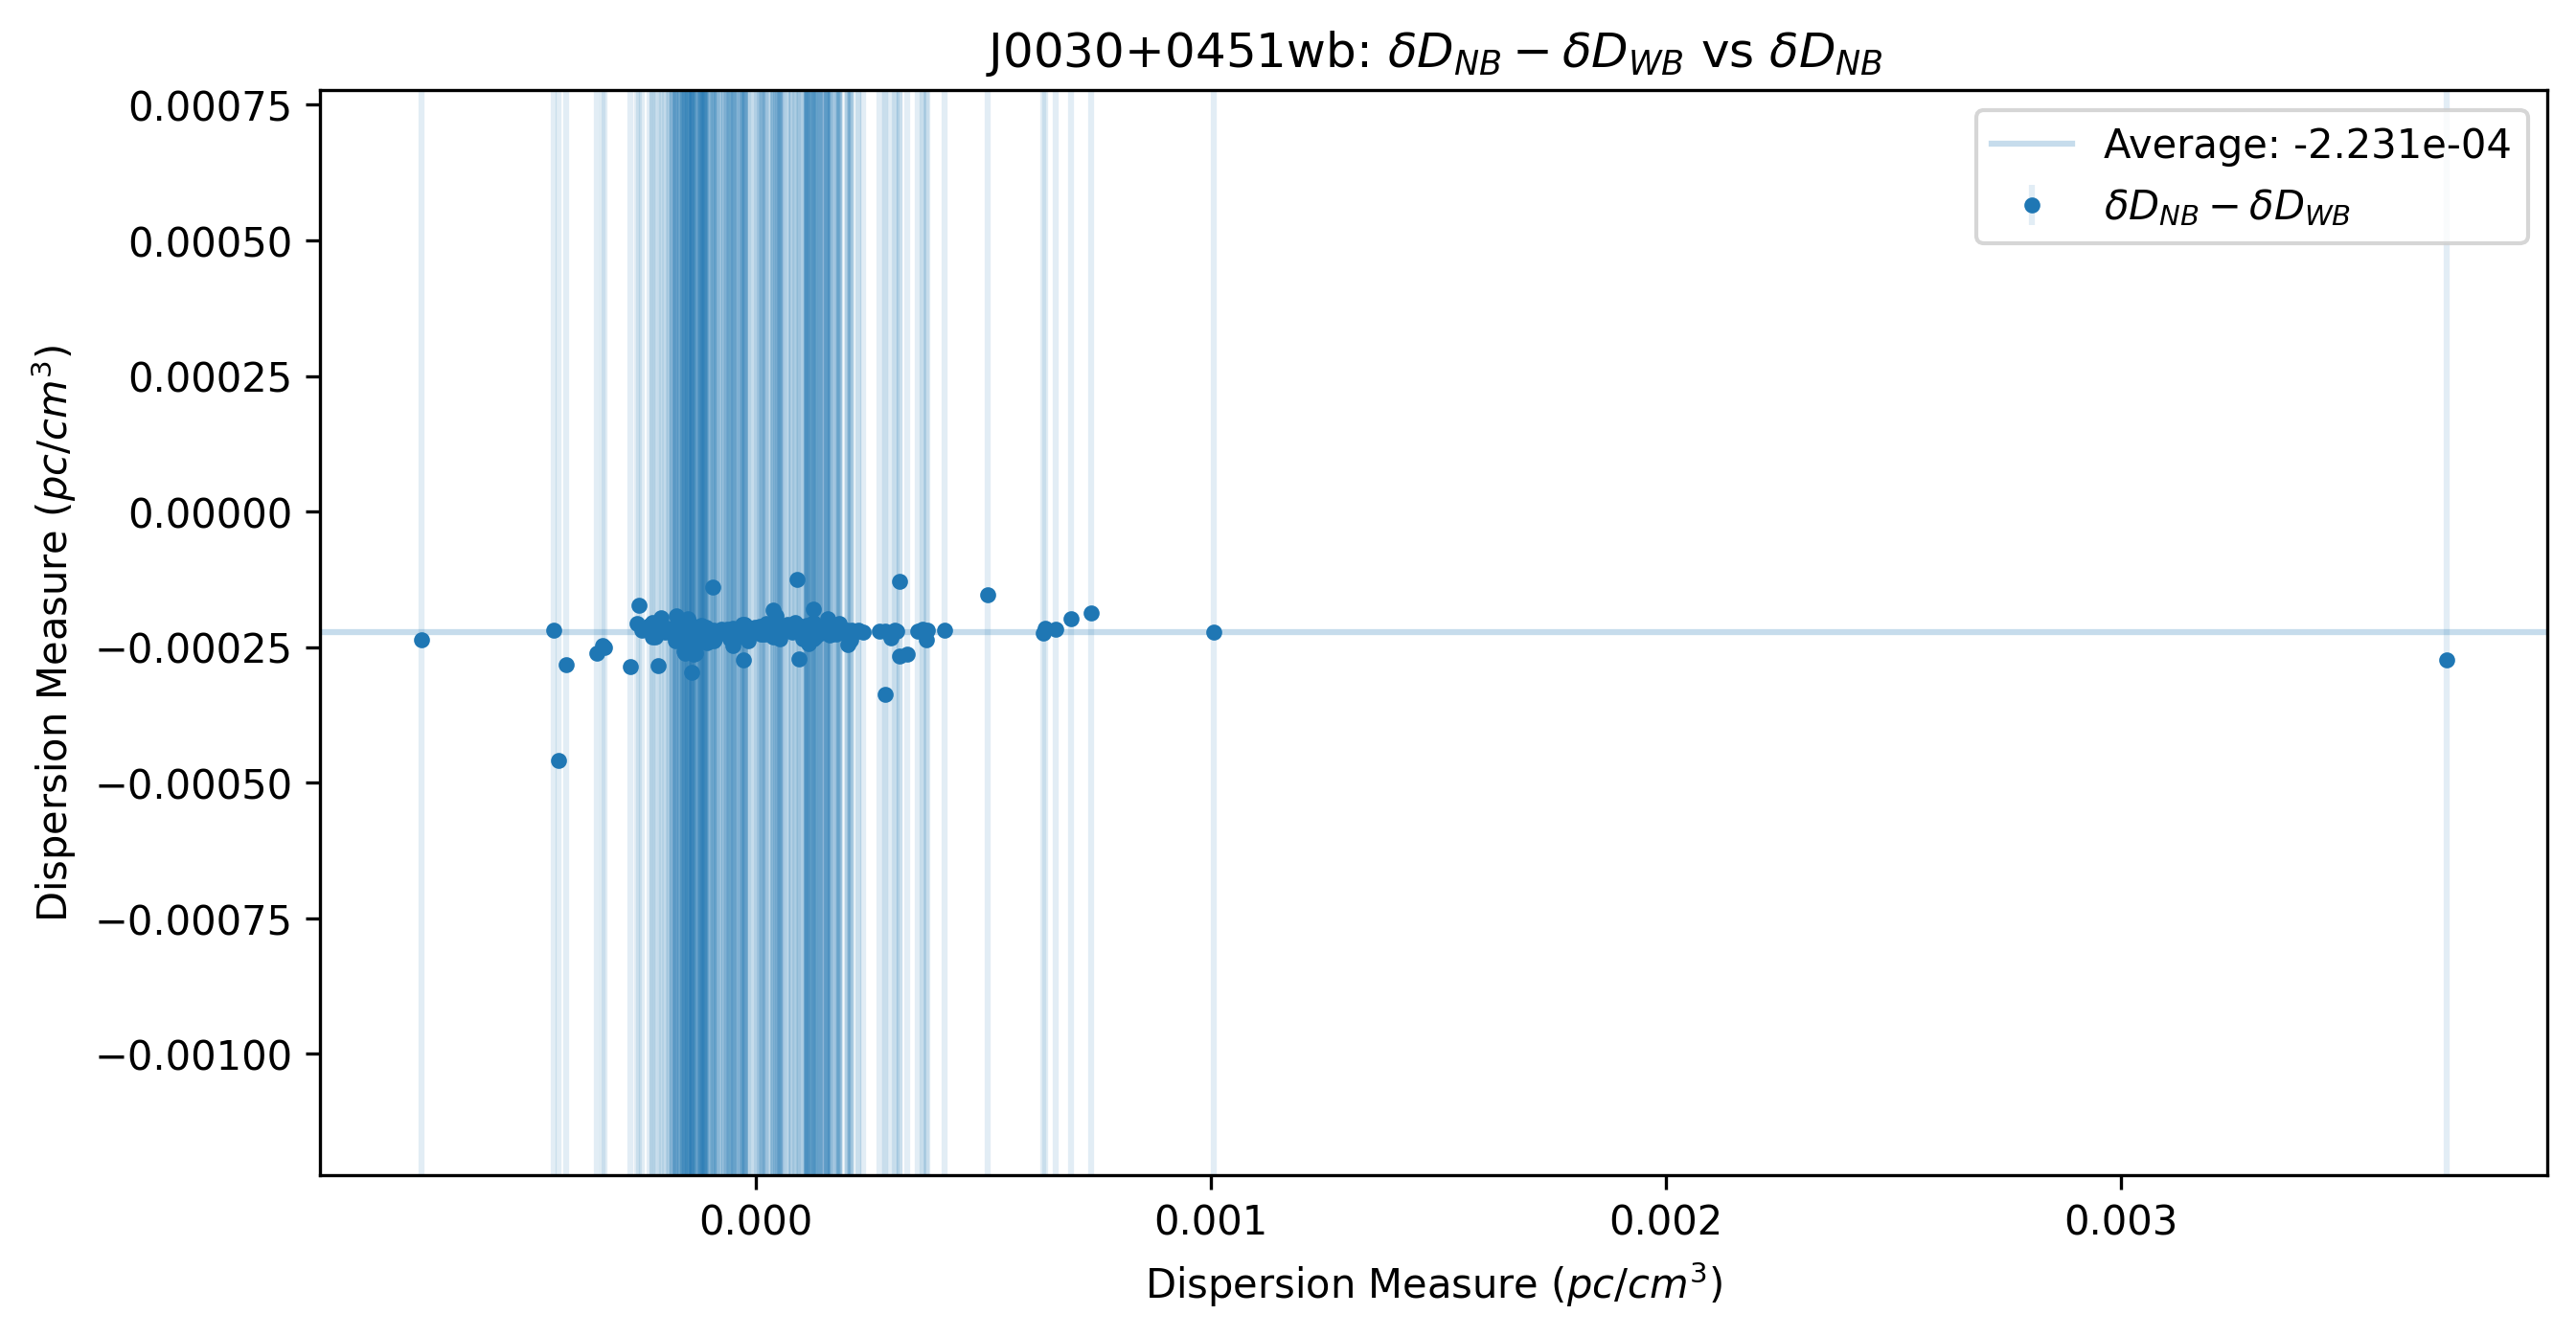

In [106]:
#compare nb data to wb data

success = False 
goodFilename2 = ""
for filename2 in os.listdir(folder): #attempt to find a corresponding wb/nb file of the current file
    try:
        filename2.index("wb" if narrowband else "nb") #try to find a filename that contains the opposide wb/nb
        filename2.index(p1.PSR) #try to find a filename that contains the pulsar's name
        success = True
        goodFilename2 = filename2
    except:
        try:
            filename2.index("WB" if narrowband else "NB") #try to find a filename that contains the opposide wb/nb
            filename2.index(p1.PSR) #try to find a filename that contains the pulsar's name
            success = True
            goodFilename2 = filename2
        except:
            continue
if success: #if one was found

    p2 = Pulsar(folder + "/" + goodFilename2) #create second pulsar object

    #make sure that they have the same points

    #nb and wb data are not necessarily taken at the same times, so we only want to compare data taken at the same time
    newp1DMXarr = [] #init arrays for new data
    newp2DMXarr = []
    newp1DMXerrarr = []
    newp2DMXerrarr = []
    newDMXEP = []
    i = 0
    j = 0
    while i < len(p1.DMXEP_ARR) and j < len(p2.DMXEP_ARR): #similar procedure as merging two sorted arrays
        if math.isclose(p1.DMXEP_ARR[i], p2.DMXEP_ARR[j], abs_tol=1e-3): #if the times are approx equal (~.001 of a day)
            newDMXEP.append(p1.DMXEP_ARR[i]) #set data aside
            newp1DMXarr.append(p1.DMX_ARR[i])
            newp1DMXerrarr.append(p1.DMX_ERROR_ARR[i])
            newp2DMXarr.append(p2.DMX_ARR[j])
            newp2DMXerrarr.append(p2.DMX_ERROR_ARR[j])
            i += 1
            j += 1
        elif p1.DMXEP_ARR[i] > p2.DMXEP_ARR[j]: #if p1 time is greater, go to the next p2 time
            j += 1
        else: #if p2 time is greater, go to the next p1 time
            i += 1

    newp1DMXarr = np.asarray(newp1DMXarr) #convert to np arrays
    newp2DMXarr = np.asarray(newp2DMXarr)
    newp1DMXerrarr = np.asarray(newp1DMXerrarr)
    newp2DMXerrarr = np.asarray(newp2DMXerrarr)
    newDMXEP = np.asarray(newDMXEP)
    nbmwberror = np.sqrt(newp1DMXerrarr**2 + newp2DMXerrarr**2) #error of the difference: add errors in quadrature

    if len(newp1DMXarr) != 0 and len(newp2DMXarr) != 0: #if there were no points in common with the wideband and narrowband timeseries, skip plotting

        #create nb vs wb time series plot
        markers, caps, bars = plt.errorbar(p1.DMXEP_ARR, p1.DMX_ARR, p1.DMX_ERROR_ARR, fmt=".") #plot p1 timeseries
        [bar.set_alpha(0.125) for bar in bars]
        markers, caps, bars = plt.errorbar(p2.DMXEP_ARR, p2.DMX_ARR, p2.DMX_ERROR_ARR, fmt=".") #plot p2 timeseries
        [bar.set_alpha(0.125) for bar in bars]
        markers, caps, bars = plt.errorbar(newDMXEP, newp1DMXarr - newp2DMXarr, nbmwberror, fmt=".") #plot difference where the timeseries had points at the same time
        [bar.set_alpha(0.125) for bar in bars]
        plt.ylabel(r"Dispersion Measure $(pc/cm^3)$")
        plt.xlabel(r"Epoch $(MJD)$")
        max = np.max(np.array([p1.DMX_ARR.max(), p2.DMX_ARR.max()])) #used to set the boundaries of the plot manually, enables the plot to actually be read
        min = np.min(np.array([p1.DMX_ARR.min(), p2.DMX_ARR.min()])) #even if the error bars are stupidly big
        diff = max-min
        plt.ylim([min - 0.2*diff, max + 0.2*diff]) #apply the bounds
        plt.legend([r"$\delta D_{NB}$", r"$\delta D_{WB}$", r"$\delta D_{NB}-\delta D_{WB}$"])
        plt.title(p1.PSR + ("nb" if narrowband else "wb") +r": Wideband vs. Narrowband $\delta D$ Time Series")
        plt.show()


        #create nb vs wb dm plot
        markers, caps, bars = plt.errorbar(newp1DMXarr, newp1DMXarr - newp2DMXarr, nbmwberror, fmt=".") #similar plot to before, but plotted as a function of DM
        avg = np.average(newp1DMXarr - newp2DMXarr)
        [bar.set_alpha(0.125) for bar in bars]
        plt.axhline(avg, alpha = 0.25)
        plt.ylabel(r"Dispersion Measure $(pc/cm^3)$")
        plt.xlabel(r"Dispersion Measure $(pc/cm^3)$")
        plt.legend(["Average: " + "{:.3e}".format(avg), r"$\delta D_{NB}-\delta D_{WB}$"])
        plt.title(p1.PSR + ("nb" if narrowband else "wb") +r": $\delta D_{NB}-\delta D_{WB}$ vs $\delta D_{NB}$")
        plt.ylim([avg - 0.001, avg + 0.001])
        plt.show()

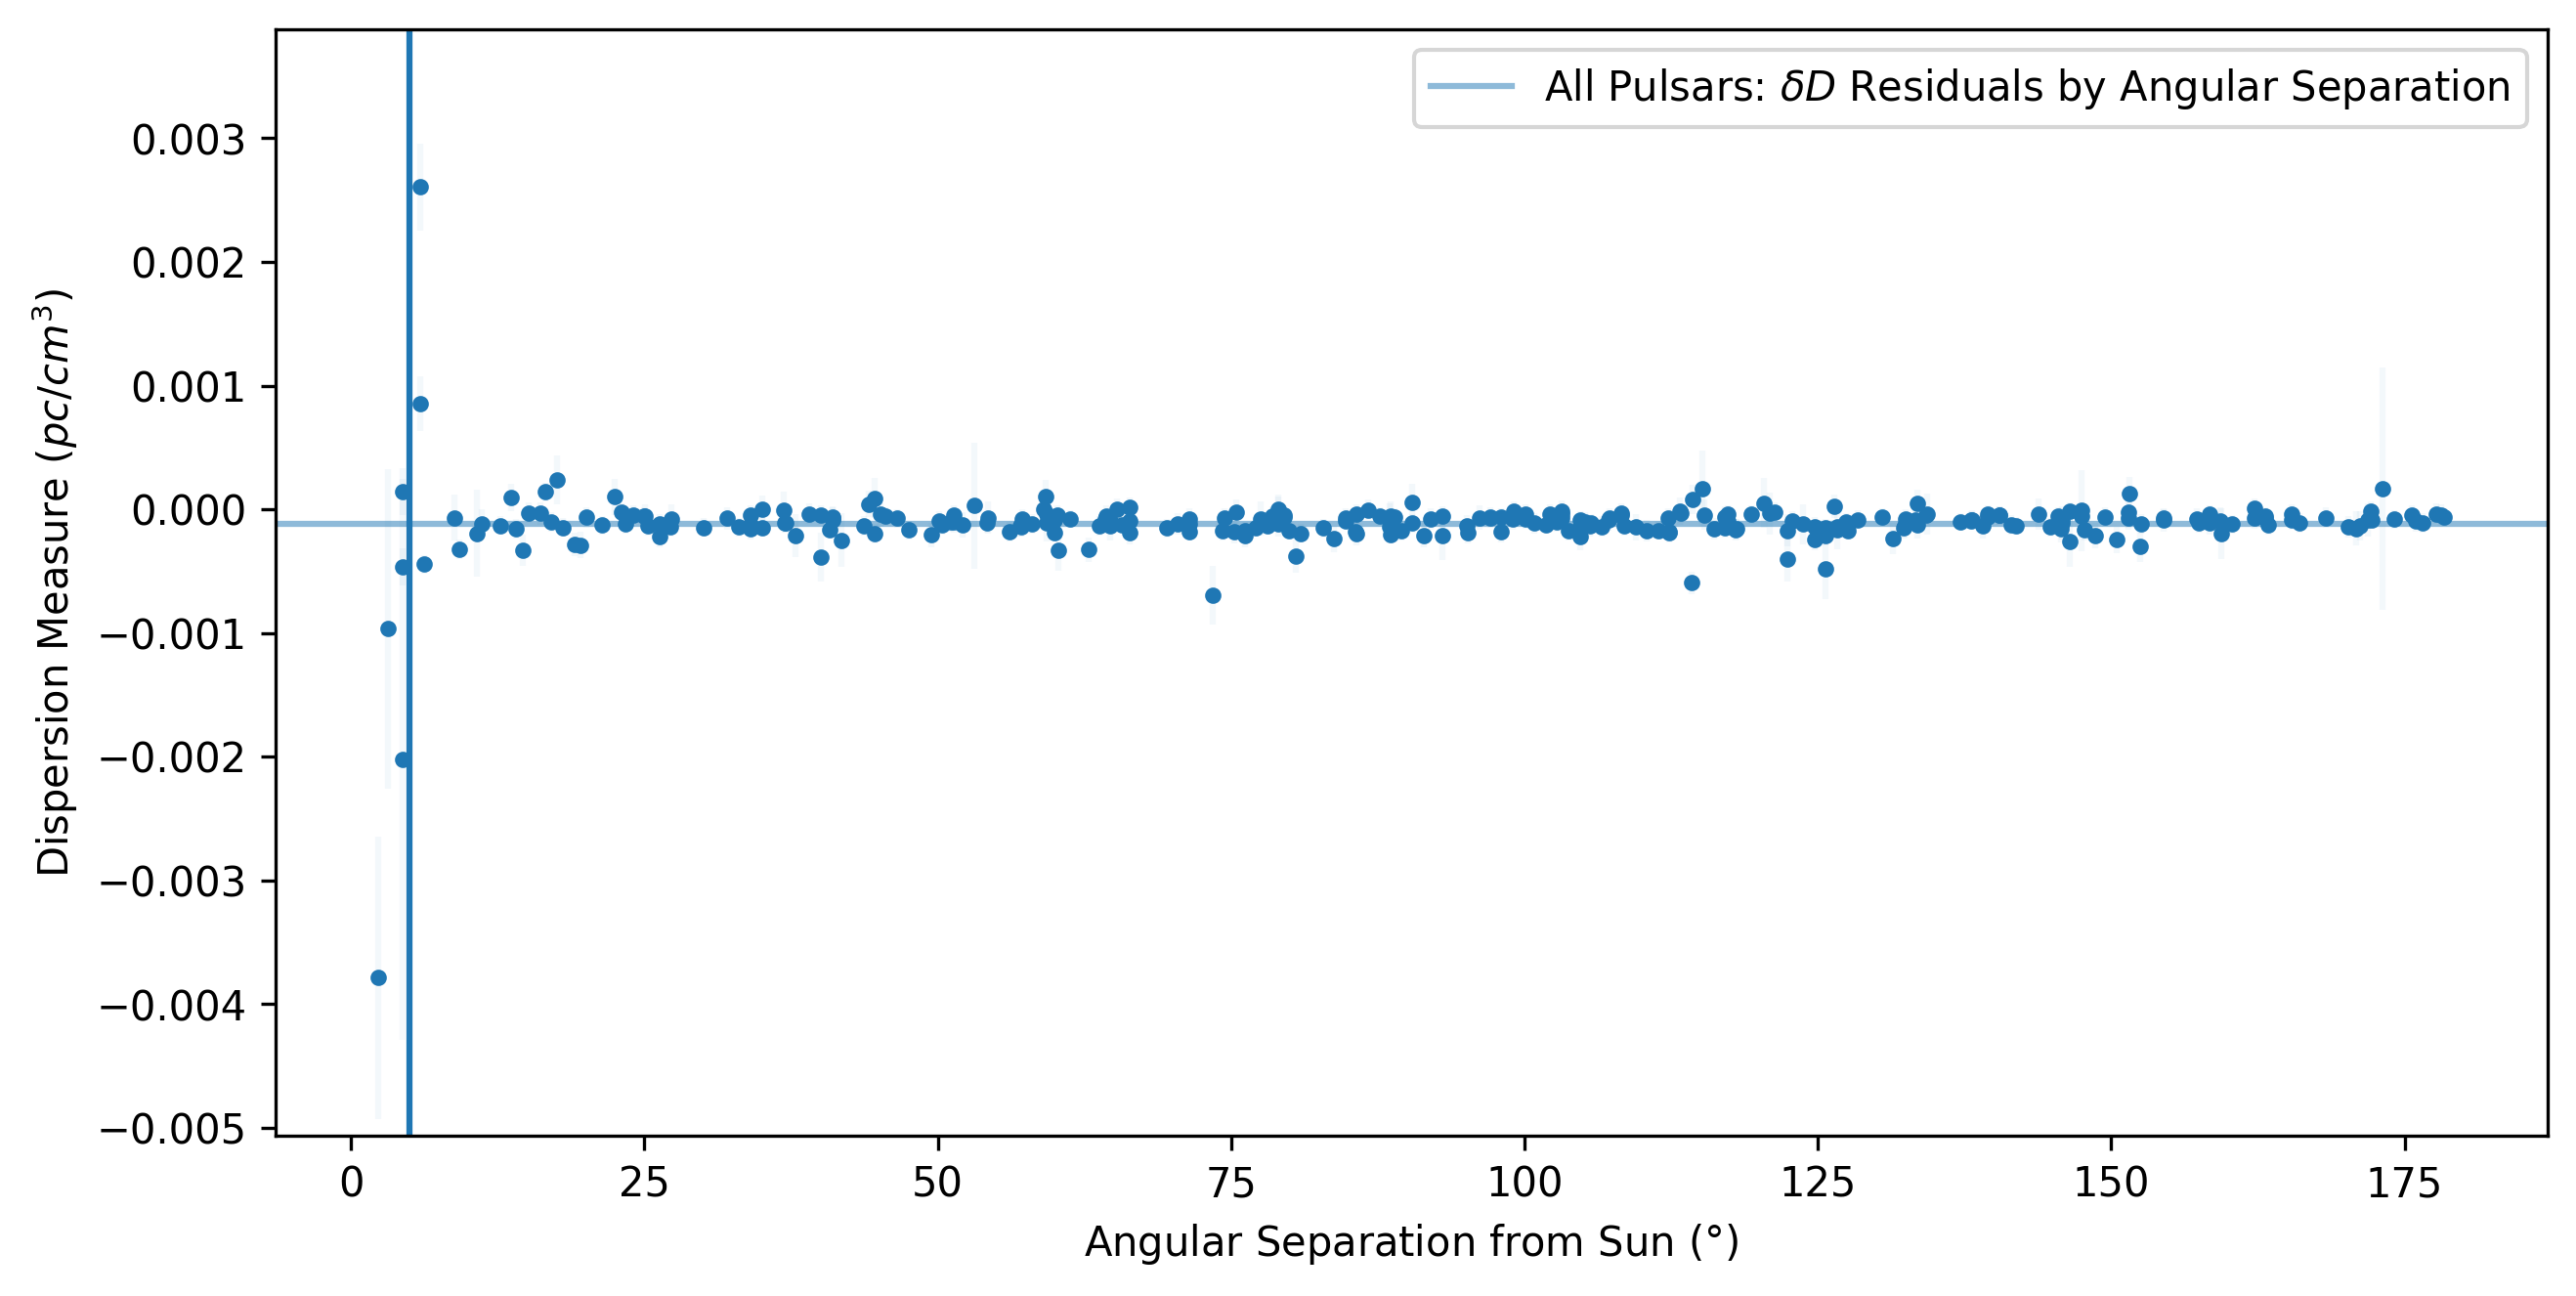

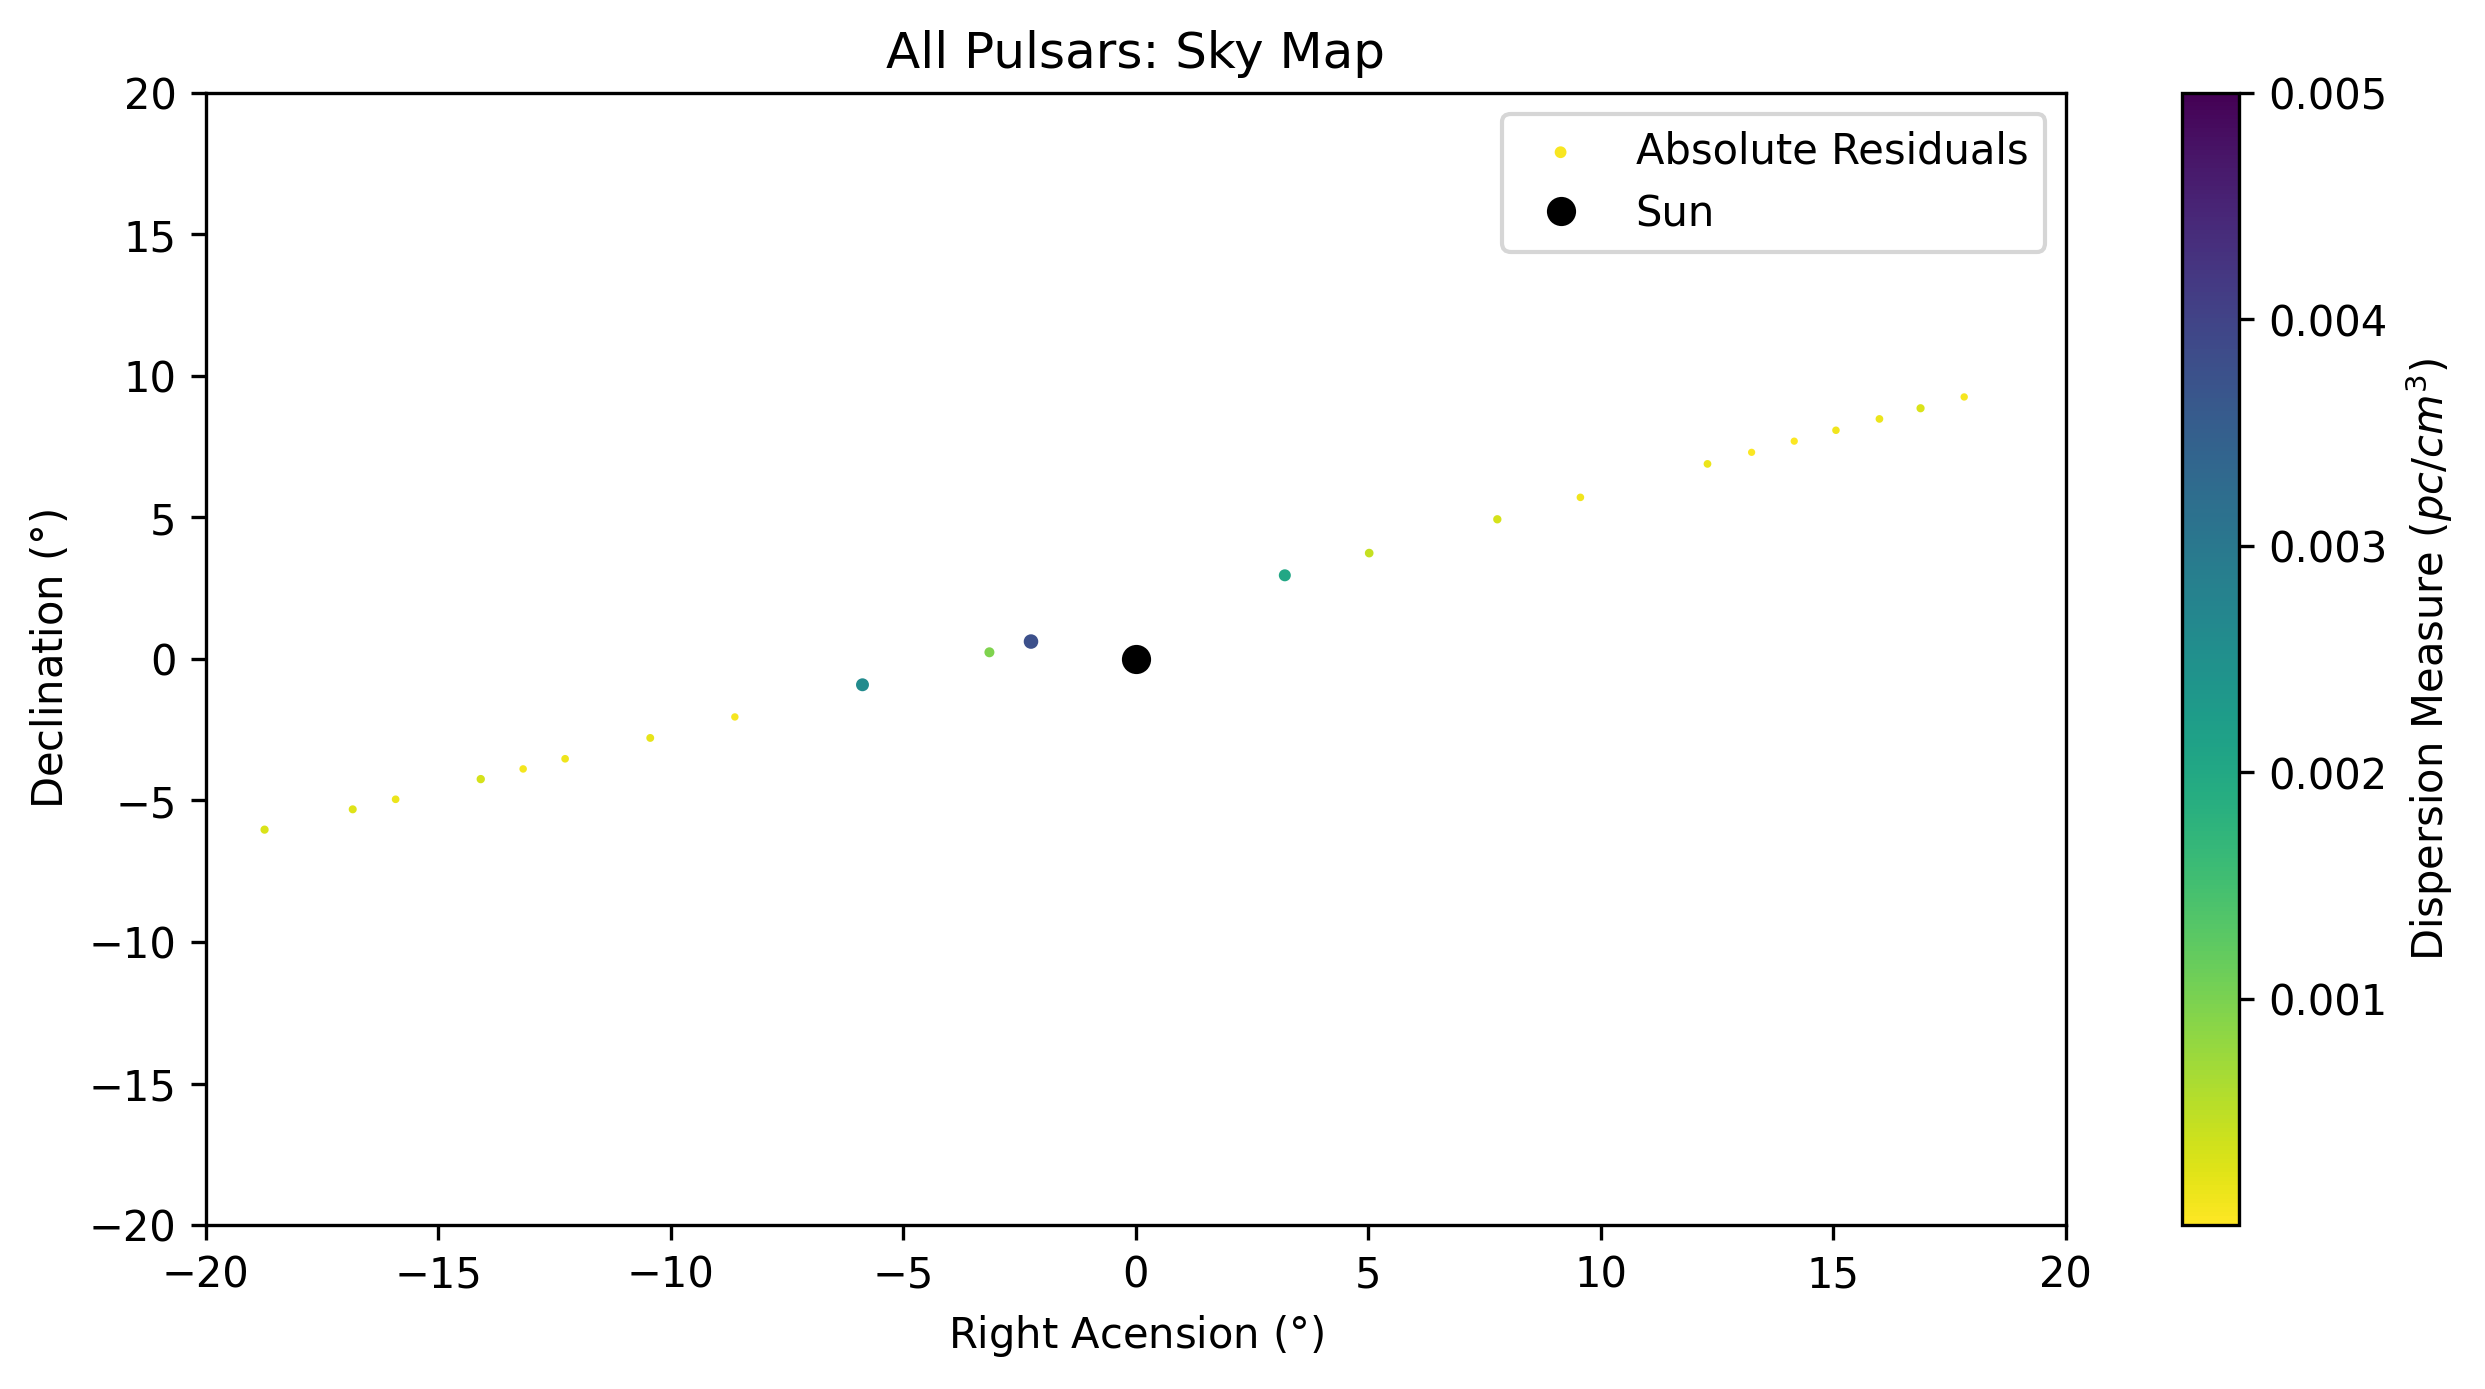

In [107]:
#create dD-Z_0-f-S by angular separation plot for all pulsars
markers, caps, bars = plt.errorbar(angsepresidx, angsepresidy, angsepreside, fmt=".")
[bar.set_alpha(0.05) for bar in bars]
diff = np.array(angsepresidy).max() - np.array(angsepresidy).min()
mean = np.mean(sortedDMXadj)
plt.axhline(mean, alpha=0.5)
plt.axvline(5, alpha=1)
plt.ylim([np.array(angsepresidy).min() - 0.2*diff, np.array(angsepresidy).max() + 0.2*diff])
plt.ylabel(r"Dispersion Measure $(pc/cm^3)$")
plt.xlabel(r"Angular Separation from Sun $(\degree)$")
plt.legend(["All Pulsars" + r": $\delta D$ Residuals by Angular Separation"])
plt.show()


#create resid skymap
residras = np.mod(np.array(residras) + 180, 360)-180 #shifted to make the plot look better
residdecs = np.mod(np.array(residdecs) + 180, 360)-180
pl1 = plt.scatter(residras, residdecs, c=np.abs(angsepresidy), vmax=0.005, s=0.5+1500*np.abs(angsepresidy), cmap="viridis_r")
plt.plot(0, 0, "o", color='black')
cb = plt.colorbar(pl1)
cb.set_label(r"Dispersion Measure $(pc/cm^3)$")
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.xlabel(r"Right Acension $(\degree)$")
plt.ylabel(r"Declination $(\degree)$")
plt.title("All Pulsars" + ": Sky Map")
plt.legend(["Absolute Residuals", "Sun"])
plt.show()